In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = ''

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0,
    'binarize'      : True,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASH = getHash(name,[architecture,props])
print(HASH)

sig_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_1_0_e_e_0_0_0_con_data_nor_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_nat_08_0_05_0


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4106669, 828)
(4106669, 7)
validation
(632885, 828)
(632885, 7)
test
(473305, 828)
(473305, 7)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 2048)              1697792   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 7)                 903       


Total params: 4485895 (17.11 MB)


Trainable params: 4485895 (17.11 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


 1/42 [..............................] - ETA: 7:56 - loss: 2.0697 - STD: 0.0699 - MAE: 0.2458

 2/42 [>.............................] - ETA: 20s - loss: 1.9967 - STD: 0.0510 - MAE: 0.2443 

 3/42 [=>............................] - ETA: 17s - loss: 1.9786 - STD: 0.0576 - MAE: 0.2428

 4/42 [=>............................] - ETA: 18s - loss: 1.9732 - STD: 0.0622 - MAE: 0.2419

 5/42 [==>...........................] - ETA: 17s - loss: 1.9688 - STD: 0.0629 - MAE: 0.2416

 6/42 [===>..........................] - ETA: 16s - loss: 1.9648 - STD: 0.0614 - MAE: 0.2416

 7/42 [====>.........................] - ETA: 16s - loss: 1.9602 - STD: 0.0591 - MAE: 0.2417

 8/42 [====>.........................] - ETA: 15s - loss: 1.9555 - STD: 0.0565 - MAE: 0.2418

 9/42 [=====>........................] - ETA: 15s - loss: 1.9513 - STD: 0.0543 - MAE: 0.2418

10/42 [======>.......................] - ETA: 14s - loss: 1.9480 - STD: 0.0527 - MAE: 0.2418

11/42 [======>.......................] - ETA: 13s - loss: 1.9455 - STD: 0.0516 - MAE: 0.2418

12/42 [=======>......................] - ETA: 13s - loss: 1.9439 - STD: 0.0508 - MAE: 0.2419

13/42 [========>.....................] - ETA: 12s - loss: 1.9424 - STD: 0.0500 - MAE: 0.2419

14/42 [=========>....................] - ETA: 12s - loss: 1.9411 - STD: 0.0492 - MAE: 0.2419

15/42 [=========>....................] - ETA: 12s - loss: 1.9397 - STD: 0.0484 - MAE: 0.2419

16/42 [==========>...................] - ETA: 12s - loss: 1.9384 - STD: 0.0476 - MAE: 0.2420

17/42 [===========>..................] - ETA: 15s - loss: 1.9384 - STD: 0.0470 - MAE: 0.2420

18/42 [===========>..................] - ETA: 14s - loss: 1.9369 - STD: 0.0464 - MAE: 0.2420

19/42 [============>.................] - ETA: 13s - loss: 1.9357 - STD: 0.0460 - MAE: 0.2420

20/42 [=============>................] - ETA: 12s - loss: 1.9345 - STD: 0.0457 - MAE: 0.2420

21/42 [==============>...............] - ETA: 12s - loss: 1.9336 - STD: 0.0456 - MAE: 0.2419

22/42 [==============>...............] - ETA: 11s - loss: 1.9327 - STD: 0.0456 - MAE: 0.2419

23/42 [===============>..............] - ETA: 10s - loss: 1.9320 - STD: 0.0455 - MAE: 0.2419

24/42 [================>.............] - ETA: 9s - loss: 1.9313 - STD: 0.0455 - MAE: 0.2419 

25/42 [================>.............] - ETA: 9s - loss: 1.9306 - STD: 0.0454 - MAE: 0.2419

26/42 [=================>............] - ETA: 8s - loss: 1.9299 - STD: 0.0452 - MAE: 0.2419

27/42 [==================>...........] - ETA: 8s - loss: 1.9291 - STD: 0.0450 - MAE: 0.2419

28/42 [===================>..........] - ETA: 7s - loss: 1.9284 - STD: 0.0447 - MAE: 0.2419

29/42 [===================>..........] - ETA: 6s - loss: 1.9277 - STD: 0.0444 - MAE: 0.2418

30/42 [====================>.........] - ETA: 6s - loss: 1.9270 - STD: 0.0441 - MAE: 0.2418

31/42 [=====================>........] - ETA: 5s - loss: 1.9263 - STD: 0.0439 - MAE: 0.2418

32/42 [=====================>........] - ETA: 5s - loss: 1.9255 - STD: 0.0437 - MAE: 0.2418

33/42 [======================>.......] - ETA: 4s - loss: 1.9247 - STD: 0.0435 - MAE: 0.2418

34/42 [=======================>......] - ETA: 4s - loss: 1.9238 - STD: 0.0434 - MAE: 0.2418

35/42 [========================>.....] - ETA: 3s - loss: 1.9228 - STD: 0.0433 - MAE: 0.2417

36/42 [========================>.....] - ETA: 3s - loss: 1.9216 - STD: 0.0431 - MAE: 0.2417

37/42 [=========================>....] - ETA: 2s - loss: 1.9203 - STD: 0.0430 - MAE: 0.2416

38/42 [==========================>...] - ETA: 2s - loss: 1.9189 - STD: 0.0430 - MAE: 0.2416

39/42 [==========================>...] - ETA: 1s - loss: 1.9173 - STD: 0.0430 - MAE: 0.2415

40/42 [===========================>..] - ETA: 1s - loss: 1.9155 - STD: 0.0432 - MAE: 0.2414

41/42 [============================>.] - ETA: 0s - loss: 1.9136 - STD: 0.0434 - MAE: 0.2413

42/42 [==============================] - ETA: 0s - loss: 1.9114 - STD: 0.0437 - MAE: 0.2411

42/42 [==============================] - 37s 624ms/step - loss: 1.9114 - STD: 0.0437 - MAE: 0.2411 - val_loss: 1.8212 - val_STD: 0.0672 - val_MAE: 0.2341


Epoch 2/10000


 1/42 [..............................] - ETA: 42s - loss: 1.8145 - STD: 0.0633 - MAE: 0.2341

 2/42 [>.............................] - ETA: 20s - loss: 1.8097 - STD: 0.0662 - MAE: 0.2335

 3/42 [=>............................] - ETA: 20s - loss: 1.8042 - STD: 0.0687 - MAE: 0.2330

 4/42 [=>............................] - ETA: 20s - loss: 1.7995 - STD: 0.0697 - MAE: 0.2326

 5/42 [==>...........................] - ETA: 18s - loss: 1.7940 - STD: 0.0709 - MAE: 0.2322

 6/42 [===>..........................] - ETA: 17s - loss: 1.7883 - STD: 0.0714 - MAE: 0.2319

 7/42 [====>.........................] - ETA: 16s - loss: 1.7828 - STD: 0.0719 - MAE: 0.2316

 8/42 [====>.........................] - ETA: 16s - loss: 1.7774 - STD: 0.0732 - MAE: 0.2311

10/42 [======>.......................] - ETA: 13s - loss: 1.7717 - STD: 0.0761 - MAE: 0.2302

11/42 [======>.......................] - ETA: 12s - loss: 1.7664 - STD: 0.0774 - MAE: 0.2298

12/42 [=======>......................] - ETA: 12s - loss: 1.7611 - STD: 0.0784 - MAE: 0.2295

13/42 [========>.....................] - ETA: 12s - loss: 1.7561 - STD: 0.0794 - MAE: 0.2291

14/42 [=========>....................] - ETA: 12s - loss: 1.7512 - STD: 0.0803 - MAE: 0.2287

15/42 [=========>....................] - ETA: 11s - loss: 1.7464 - STD: 0.0814 - MAE: 0.2283

16/42 [==========>...................] - ETA: 11s - loss: 1.7418 - STD: 0.0829 - MAE: 0.2279

17/42 [===========>..................] - ETA: 11s - loss: 1.7374 - STD: 0.0840 - MAE: 0.2275

18/42 [===========>..................] - ETA: 10s - loss: 1.7328 - STD: 0.0850 - MAE: 0.2271

19/42 [============>.................] - ETA: 10s - loss: 1.7288 - STD: 0.0860 - MAE: 0.2267

20/42 [=============>................] - ETA: 9s - loss: 1.7252 - STD: 0.0868 - MAE: 0.2264 

21/42 [==============>...............] - ETA: 9s - loss: 1.7212 - STD: 0.0878 - MAE: 0.2260

22/42 [==============>...............] - ETA: 8s - loss: 1.7173 - STD: 0.0889 - MAE: 0.2257

23/42 [===============>..............] - ETA: 8s - loss: 1.7139 - STD: 0.0897 - MAE: 0.2254

24/42 [================>.............] - ETA: 7s - loss: 1.7101 - STD: 0.0906 - MAE: 0.2250

25/42 [================>.............] - ETA: 7s - loss: 1.7064 - STD: 0.0915 - MAE: 0.2247

26/42 [=================>............] - ETA: 7s - loss: 1.7029 - STD: 0.0922 - MAE: 0.2244

27/42 [==================>...........] - ETA: 6s - loss: 1.6996 - STD: 0.0933 - MAE: 0.2240

28/42 [===================>..........] - ETA: 6s - loss: 1.6962 - STD: 0.0941 - MAE: 0.2237

29/42 [===================>..........] - ETA: 5s - loss: 1.6928 - STD: 0.0949 - MAE: 0.2234

30/42 [====================>.........] - ETA: 5s - loss: 1.6895 - STD: 0.0958 - MAE: 0.2230

31/42 [=====================>........] - ETA: 4s - loss: 1.6866 - STD: 0.0963 - MAE: 0.2228

32/42 [=====================>........] - ETA: 4s - loss: 1.6836 - STD: 0.0974 - MAE: 0.2224

33/42 [======================>.......] - ETA: 3s - loss: 1.6806 - STD: 0.0980 - MAE: 0.2222

34/42 [=======================>......] - ETA: 3s - loss: 1.6774 - STD: 0.0987 - MAE: 0.2219

35/42 [========================>.....] - ETA: 3s - loss: 1.6743 - STD: 0.0996 - MAE: 0.2216

36/42 [========================>.....] - ETA: 2s - loss: 1.6716 - STD: 0.1001 - MAE: 0.2214

37/42 [=========================>....] - ETA: 2s - loss: 1.6687 - STD: 0.1010 - MAE: 0.2210

38/42 [==========================>...] - ETA: 1s - loss: 1.6656 - STD: 0.1016 - MAE: 0.2208

39/42 [==========================>...] - ETA: 1s - loss: 1.6628 - STD: 0.1021 - MAE: 0.2205

40/42 [===========================>..] - ETA: 0s - loss: 1.6600 - STD: 0.1030 - MAE: 0.2202

41/42 [============================>.] - ETA: 0s - loss: 1.6570 - STD: 0.1035 - MAE: 0.2200

42/42 [==============================] - ETA: 0s - loss: 1.6541 - STD: 0.1041 - MAE: 0.2197

42/42 [==============================] - 21s 497ms/step - loss: 1.6541 - STD: 0.1041 - MAE: 0.2197 - val_loss: 1.5868 - val_STD: 0.1298 - val_MAE: 0.2111


Epoch 3/10000


 1/42 [..............................] - ETA: 35s - loss: 1.5302 - STD: 0.1329 - MAE: 0.2078

 2/42 [>.............................] - ETA: 16s - loss: 1.5300 - STD: 0.1285 - MAE: 0.2089

 3/42 [=>............................] - ETA: 15s - loss: 1.5271 - STD: 0.1306 - MAE: 0.2082

 4/42 [=>............................] - ETA: 15s - loss: 1.5219 - STD: 0.1306 - MAE: 0.2080

 5/42 [==>...........................] - ETA: 14s - loss: 1.5173 - STD: 0.1305 - MAE: 0.2078

 6/42 [===>..........................] - ETA: 14s - loss: 1.5139 - STD: 0.1316 - MAE: 0.2074

 7/42 [====>.........................] - ETA: 13s - loss: 1.5101 - STD: 0.1313 - MAE: 0.2073

 8/42 [====>.........................] - ETA: 13s - loss: 1.5064 - STD: 0.1324 - MAE: 0.2068

 9/42 [=====>........................] - ETA: 13s - loss: 1.5016 - STD: 0.1323 - MAE: 0.2066

11/42 [======>.......................] - ETA: 11s - loss: 1.4944 - STD: 0.1337 - MAE: 0.2057

12/42 [=======>......................] - ETA: 11s - loss: 1.4884 - STD: 0.1342 - MAE: 0.2054

13/42 [========>.....................] - ETA: 10s - loss: 1.4822 - STD: 0.1351 - MAE: 0.2049

14/42 [=========>....................] - ETA: 10s - loss: 1.4757 - STD: 0.1355 - MAE: 0.2045

15/42 [=========>....................] - ETA: 10s - loss: 1.4702 - STD: 0.1365 - MAE: 0.2040

16/42 [==========>...................] - ETA: 9s - loss: 1.4655 - STD: 0.1368 - MAE: 0.2038 

17/42 [===========>..................] - ETA: 9s - loss: 1.4617 - STD: 0.1377 - MAE: 0.2034

18/42 [===========>..................] - ETA: 9s - loss: 1.4562 - STD: 0.1384 - MAE: 0.2030

19/42 [============>.................] - ETA: 9s - loss: 1.4522 - STD: 0.1389 - MAE: 0.2026

20/42 [=============>................] - ETA: 8s - loss: 1.4480 - STD: 0.1397 - MAE: 0.2022

21/42 [==============>...............] - ETA: 8s - loss: 1.4434 - STD: 0.1407 - MAE: 0.2018

22/42 [==============>...............] - ETA: 8s - loss: 1.4401 - STD: 0.1412 - MAE: 0.2015

23/42 [===============>..............] - ETA: 7s - loss: 1.4351 - STD: 0.1419 - MAE: 0.2011

24/42 [================>.............] - ETA: 7s - loss: 1.4319 - STD: 0.1427 - MAE: 0.2007

25/42 [================>.............] - ETA: 6s - loss: 1.4275 - STD: 0.1433 - MAE: 0.2003

26/42 [=================>............] - ETA: 6s - loss: 1.4239 - STD: 0.1438 - MAE: 0.2000

27/42 [==================>...........] - ETA: 6s - loss: 1.4199 - STD: 0.1444 - MAE: 0.1997

28/42 [===================>..........] - ETA: 5s - loss: 1.4165 - STD: 0.1451 - MAE: 0.1993

29/42 [===================>..........] - ETA: 5s - loss: 1.4130 - STD: 0.1456 - MAE: 0.1990

30/42 [====================>.........] - ETA: 4s - loss: 1.4096 - STD: 0.1461 - MAE: 0.1987

31/42 [=====================>........] - ETA: 4s - loss: 1.4062 - STD: 0.1466 - MAE: 0.1984

32/42 [=====================>........] - ETA: 4s - loss: 1.4029 - STD: 0.1471 - MAE: 0.1981

33/42 [======================>.......] - ETA: 3s - loss: 1.3999 - STD: 0.1476 - MAE: 0.1978

34/42 [=======================>......] - ETA: 3s - loss: 1.3967 - STD: 0.1480 - MAE: 0.1976

35/42 [========================>.....] - ETA: 2s - loss: 1.3938 - STD: 0.1485 - MAE: 0.1973

36/42 [========================>.....] - ETA: 2s - loss: 1.3909 - STD: 0.1489 - MAE: 0.1970

37/42 [=========================>....] - ETA: 2s - loss: 1.3882 - STD: 0.1494 - MAE: 0.1968

38/42 [==========================>...] - ETA: 1s - loss: 1.3854 - STD: 0.1498 - MAE: 0.1965

39/42 [==========================>...] - ETA: 1s - loss: 1.3828 - STD: 0.1503 - MAE: 0.1962

40/42 [===========================>..] - ETA: 0s - loss: 1.3801 - STD: 0.1507 - MAE: 0.1960

41/42 [============================>.] - ETA: 0s - loss: 1.3776 - STD: 0.1511 - MAE: 0.1957

42/42 [==============================] - ETA: 0s - loss: 1.3751 - STD: 0.1515 - MAE: 0.1955

42/42 [==============================] - 20s 469ms/step - loss: 1.3751 - STD: 0.1515 - MAE: 0.1955 - val_loss: 1.3252 - val_STD: 0.1683 - val_MAE: 0.1884


Epoch 4/10000


 1/42 [..............................] - ETA: 33s - loss: 1.2727 - STD: 0.1696 - MAE: 0.1851

 2/42 [>.............................] - ETA: 16s - loss: 1.2724 - STD: 0.1690 - MAE: 0.1854

 3/42 [=>............................] - ETA: 16s - loss: 1.2714 - STD: 0.1688 - MAE: 0.1854

 4/42 [=>............................] - ETA: 16s - loss: 1.2700 - STD: 0.1692 - MAE: 0.1852

 5/42 [==>...........................] - ETA: 15s - loss: 1.2689 - STD: 0.1694 - MAE: 0.1850

 6/42 [===>..........................] - ETA: 15s - loss: 1.2685 - STD: 0.1693 - MAE: 0.1850

 7/42 [====>.........................] - ETA: 14s - loss: 1.2672 - STD: 0.1694 - MAE: 0.1849

 8/42 [====>.........................] - ETA: 14s - loss: 1.2659 - STD: 0.1697 - MAE: 0.1847

 9/42 [=====>........................] - ETA: 14s - loss: 1.2653 - STD: 0.1699 - MAE: 0.1846

10/42 [======>.......................] - ETA: 13s - loss: 1.2643 - STD: 0.1701 - MAE: 0.1845

11/42 [======>.......................] - ETA: 13s - loss: 1.2636 - STD: 0.1703 - MAE: 0.1844

12/42 [=======>......................] - ETA: 12s - loss: 1.2630 - STD: 0.1707 - MAE: 0.1842

13/42 [========>.....................] - ETA: 12s - loss: 1.2645 - STD: 0.1707 - MAE: 0.1843

14/42 [=========>....................] - ETA: 12s - loss: 1.2679 - STD: 0.1710 - MAE: 0.1844

15/42 [=========>....................] - ETA: 11s - loss: 1.2690 - STD: 0.1710 - MAE: 0.1844

16/42 [==========>...................] - ETA: 11s - loss: 1.2677 - STD: 0.1711 - MAE: 0.1843

17/42 [===========>..................] - ETA: 10s - loss: 1.2678 - STD: 0.1713 - MAE: 0.1842

18/42 [===========>..................] - ETA: 10s - loss: 1.2679 - STD: 0.1714 - MAE: 0.1842

19/42 [============>.................] - ETA: 10s - loss: 1.2665 - STD: 0.1715 - MAE: 0.1841

20/42 [=============>................] - ETA: 9s - loss: 1.2660 - STD: 0.1717 - MAE: 0.1840 

21/42 [==============>...............] - ETA: 9s - loss: 1.2657 - STD: 0.1717 - MAE: 0.1840

22/42 [==============>...............] - ETA: 8s - loss: 1.2643 - STD: 0.1718 - MAE: 0.1839

23/42 [===============>..............] - ETA: 8s - loss: 1.2638 - STD: 0.1720 - MAE: 0.1838

24/42 [================>.............] - ETA: 8s - loss: 1.2632 - STD: 0.1720 - MAE: 0.1838

25/42 [================>.............] - ETA: 7s - loss: 1.2625 - STD: 0.1721 - MAE: 0.1837

26/42 [=================>............] - ETA: 7s - loss: 1.2620 - STD: 0.1722 - MAE: 0.1836

27/42 [==================>...........] - ETA: 6s - loss: 1.2611 - STD: 0.1723 - MAE: 0.1835

28/42 [===================>..........] - ETA: 6s - loss: 1.2602 - STD: 0.1724 - MAE: 0.1835

29/42 [===================>..........] - ETA: 5s - loss: 1.2594 - STD: 0.1725 - MAE: 0.1834

30/42 [====================>.........] - ETA: 5s - loss: 1.2587 - STD: 0.1726 - MAE: 0.1833

31/42 [=====================>........] - ETA: 4s - loss: 1.2579 - STD: 0.1728 - MAE: 0.1832

33/42 [======================>.......] - ETA: 3s - loss: 1.2571 - STD: 0.1730 - MAE: 0.1831

34/42 [=======================>......] - ETA: 3s - loss: 1.2563 - STD: 0.1730 - MAE: 0.1830

35/42 [========================>.....] - ETA: 3s - loss: 1.2556 - STD: 0.1731 - MAE: 0.1830

36/42 [========================>.....] - ETA: 2s - loss: 1.2549 - STD: 0.1732 - MAE: 0.1829

37/42 [=========================>....] - ETA: 2s - loss: 1.2542 - STD: 0.1732 - MAE: 0.1828

38/42 [==========================>...] - ETA: 1s - loss: 1.2535 - STD: 0.1733 - MAE: 0.1828

39/42 [==========================>...] - ETA: 1s - loss: 1.2528 - STD: 0.1734 - MAE: 0.1827

40/42 [===========================>..] - ETA: 0s - loss: 1.2521 - STD: 0.1735 - MAE: 0.1826

41/42 [============================>.] - ETA: 0s - loss: 1.2514 - STD: 0.1736 - MAE: 0.1826

42/42 [==============================] - ETA: 0s - loss: 1.2507 - STD: 0.1737 - MAE: 0.1825

42/42 [==============================] - 21s 491ms/step - loss: 1.2507 - STD: 0.1737 - MAE: 0.1825 - val_loss: 1.2818 - val_STD: 0.1777 - val_MAE: 0.1827


Epoch 5/10000


 1/42 [..............................] - ETA: 35s - loss: 1.2207 - STD: 0.1791 - MAE: 0.1788

 2/42 [>.............................] - ETA: 18s - loss: 1.2213 - STD: 0.1790 - MAE: 0.1790

 3/42 [=>............................] - ETA: 17s - loss: 1.2207 - STD: 0.1788 - MAE: 0.1791

 4/42 [=>............................] - ETA: 16s - loss: 1.2214 - STD: 0.1787 - MAE: 0.1791

 5/42 [==>...........................] - ETA: 16s - loss: 1.2216 - STD: 0.1786 - MAE: 0.1792

 6/42 [===>..........................] - ETA: 16s - loss: 1.2210 - STD: 0.1785 - MAE: 0.1792

 7/42 [====>.........................] - ETA: 15s - loss: 1.2203 - STD: 0.1785 - MAE: 0.1791

 8/42 [====>.........................] - ETA: 14s - loss: 1.2193 - STD: 0.1785 - MAE: 0.1790

 9/42 [=====>........................] - ETA: 14s - loss: 1.2187 - STD: 0.1786 - MAE: 0.1790

10/42 [======>.......................] - ETA: 13s - loss: 1.2182 - STD: 0.1786 - MAE: 0.1789

11/42 [======>.......................] - ETA: 13s - loss: 1.2177 - STD: 0.1787 - MAE: 0.1789

12/42 [=======>......................] - ETA: 12s - loss: 1.2171 - STD: 0.1788 - MAE: 0.1788

13/42 [========>.....................] - ETA: 12s - loss: 1.2166 - STD: 0.1789 - MAE: 0.1788

14/42 [=========>....................] - ETA: 11s - loss: 1.2161 - STD: 0.1790 - MAE: 0.1787

15/42 [=========>....................] - ETA: 11s - loss: 1.2157 - STD: 0.1790 - MAE: 0.1787

16/42 [==========>...................] - ETA: 11s - loss: 1.2153 - STD: 0.1791 - MAE: 0.1786

17/42 [===========>..................] - ETA: 10s - loss: 1.2152 - STD: 0.1791 - MAE: 0.1786

18/42 [===========>..................] - ETA: 10s - loss: 1.2148 - STD: 0.1792 - MAE: 0.1785

19/42 [============>.................] - ETA: 10s - loss: 1.2146 - STD: 0.1793 - MAE: 0.1785

20/42 [=============>................] - ETA: 9s - loss: 1.2145 - STD: 0.1794 - MAE: 0.1784 

21/42 [==============>...............] - ETA: 9s - loss: 1.2140 - STD: 0.1794 - MAE: 0.1784

22/42 [==============>...............] - ETA: 8s - loss: 1.2133 - STD: 0.1796 - MAE: 0.1783

23/42 [===============>..............] - ETA: 8s - loss: 1.2126 - STD: 0.1796 - MAE: 0.1782

25/42 [================>.............] - ETA: 7s - loss: 1.2124 - STD: 0.1799 - MAE: 0.1780

26/42 [=================>............] - ETA: 6s - loss: 1.2126 - STD: 0.1799 - MAE: 0.1780

27/42 [==================>...........] - ETA: 6s - loss: 1.2122 - STD: 0.1800 - MAE: 0.1780

28/42 [===================>..........] - ETA: 6s - loss: 1.2121 - STD: 0.1801 - MAE: 0.1779

29/42 [===================>..........] - ETA: 5s - loss: 1.2118 - STD: 0.1802 - MAE: 0.1779

30/42 [====================>.........] - ETA: 5s - loss: 1.2113 - STD: 0.1803 - MAE: 0.1778

31/42 [=====================>........] - ETA: 4s - loss: 1.2105 - STD: 0.1803 - MAE: 0.1778

32/42 [=====================>........] - ETA: 4s - loss: 1.2101 - STD: 0.1803 - MAE: 0.1777

33/42 [======================>.......] - ETA: 3s - loss: 1.2095 - STD: 0.1805 - MAE: 0.1777

34/42 [=======================>......] - ETA: 3s - loss: 1.2089 - STD: 0.1806 - MAE: 0.1776

35/42 [========================>.....] - ETA: 3s - loss: 1.2082 - STD: 0.1806 - MAE: 0.1775

36/42 [========================>.....] - ETA: 2s - loss: 1.2078 - STD: 0.1807 - MAE: 0.1775

37/42 [=========================>....] - ETA: 2s - loss: 1.2073 - STD: 0.1807 - MAE: 0.1774

38/42 [==========================>...] - ETA: 1s - loss: 1.2068 - STD: 0.1808 - MAE: 0.1773

39/42 [==========================>...] - ETA: 1s - loss: 1.2062 - STD: 0.1810 - MAE: 0.1773

40/42 [===========================>..] - ETA: 0s - loss: 1.2060 - STD: 0.1810 - MAE: 0.1773

41/42 [============================>.] - ETA: 0s - loss: 1.2056 - STD: 0.1811 - MAE: 0.1772

42/42 [==============================] - ETA: 0s - loss: 1.2050 - STD: 0.1812 - MAE: 0.1771

42/42 [==============================] - 23s 533ms/step - loss: 1.2050 - STD: 0.1812 - MAE: 0.1771 - val_loss: 1.2302 - val_STD: 0.1817 - val_MAE: 0.1780


Epoch 6/10000


 1/42 [..............................] - ETA: 40s - loss: 1.1828 - STD: 0.1841 - MAE: 0.1746

 2/42 [>.............................] - ETA: 16s - loss: 1.1823 - STD: 0.1860 - MAE: 0.1738

 3/42 [=>............................] - ETA: 17s - loss: 1.1802 - STD: 0.1854 - MAE: 0.1739

 4/42 [=>............................] - ETA: 19s - loss: 1.1785 - STD: 0.1852 - MAE: 0.1739

 5/42 [==>...........................] - ETA: 18s - loss: 1.1790 - STD: 0.1858 - MAE: 0.1737

 6/42 [===>..........................] - ETA: 17s - loss: 1.1785 - STD: 0.1855 - MAE: 0.1738

 7/42 [====>.........................] - ETA: 17s - loss: 1.1768 - STD: 0.1856 - MAE: 0.1736

 8/42 [====>.........................] - ETA: 16s - loss: 1.1757 - STD: 0.1859 - MAE: 0.1734

 9/42 [=====>........................] - ETA: 16s - loss: 1.1753 - STD: 0.1857 - MAE: 0.1735

10/42 [======>.......................] - ETA: 15s - loss: 1.1742 - STD: 0.1859 - MAE: 0.1733

11/42 [======>.......................] - ETA: 15s - loss: 1.1731 - STD: 0.1861 - MAE: 0.1732

12/42 [=======>......................] - ETA: 14s - loss: 1.1726 - STD: 0.1861 - MAE: 0.1731

13/42 [========>.....................] - ETA: 13s - loss: 1.1720 - STD: 0.1864 - MAE: 0.1730

14/42 [=========>....................] - ETA: 13s - loss: 1.1718 - STD: 0.1866 - MAE: 0.1729

15/42 [=========>....................] - ETA: 13s - loss: 1.1721 - STD: 0.1866 - MAE: 0.1729

16/42 [==========>...................] - ETA: 12s - loss: 1.1726 - STD: 0.1869 - MAE: 0.1728

17/42 [===========>..................] - ETA: 12s - loss: 1.1725 - STD: 0.1870 - MAE: 0.1727

18/42 [===========>..................] - ETA: 11s - loss: 1.1724 - STD: 0.1871 - MAE: 0.1727

19/42 [============>.................] - ETA: 10s - loss: 1.1712 - STD: 0.1872 - MAE: 0.1725

20/42 [=============>................] - ETA: 10s - loss: 1.1701 - STD: 0.1875 - MAE: 0.1724

21/42 [==============>...............] - ETA: 9s - loss: 1.1697 - STD: 0.1876 - MAE: 0.1723 

22/42 [==============>...............] - ETA: 9s - loss: 1.1690 - STD: 0.1879 - MAE: 0.1721

23/42 [===============>..............] - ETA: 8s - loss: 1.1685 - STD: 0.1881 - MAE: 0.1720

24/42 [================>.............] - ETA: 8s - loss: 1.1681 - STD: 0.1882 - MAE: 0.1720

25/42 [================>.............] - ETA: 7s - loss: 1.1668 - STD: 0.1884 - MAE: 0.1718

26/42 [=================>............] - ETA: 7s - loss: 1.1663 - STD: 0.1886 - MAE: 0.1717

27/42 [==================>...........] - ETA: 7s - loss: 1.1661 - STD: 0.1886 - MAE: 0.1717

28/42 [===================>..........] - ETA: 6s - loss: 1.1652 - STD: 0.1886 - MAE: 0.1717

29/42 [===================>..........] - ETA: 6s - loss: 1.1656 - STD: 0.1890 - MAE: 0.1715

30/42 [====================>.........] - ETA: 5s - loss: 1.1652 - STD: 0.1891 - MAE: 0.1715

31/42 [=====================>........] - ETA: 5s - loss: 1.1653 - STD: 0.1892 - MAE: 0.1715

32/42 [=====================>........] - ETA: 4s - loss: 1.1644 - STD: 0.1894 - MAE: 0.1713

33/42 [======================>.......] - ETA: 4s - loss: 1.1641 - STD: 0.1897 - MAE: 0.1712

34/42 [=======================>......] - ETA: 3s - loss: 1.1633 - STD: 0.1898 - MAE: 0.1712

35/42 [========================>.....] - ETA: 3s - loss: 1.1629 - STD: 0.1899 - MAE: 0.1711

36/42 [========================>.....] - ETA: 2s - loss: 1.1620 - STD: 0.1900 - MAE: 0.1710

37/42 [=========================>....] - ETA: 2s - loss: 1.1618 - STD: 0.1902 - MAE: 0.1709

38/42 [==========================>...] - ETA: 1s - loss: 1.1608 - STD: 0.1902 - MAE: 0.1708

39/42 [==========================>...] - ETA: 1s - loss: 1.1604 - STD: 0.1903 - MAE: 0.1708

40/42 [===========================>..] - ETA: 0s - loss: 1.1596 - STD: 0.1904 - MAE: 0.1707

41/42 [============================>.] - ETA: 0s - loss: 1.1590 - STD: 0.1906 - MAE: 0.1706

42/42 [==============================] - ETA: 0s - loss: 1.1582 - STD: 0.1907 - MAE: 0.1705

42/42 [==============================] - 24s 558ms/step - loss: 1.1582 - STD: 0.1907 - MAE: 0.1705 - val_loss: 1.2042 - val_STD: 0.1928 - val_MAE: 0.1731


Epoch 7/10000


 1/42 [..............................] - ETA: 32s - loss: 1.1373 - STD: 0.1939 - MAE: 0.1682

 2/42 [>.............................] - ETA: 17s - loss: 1.1321 - STD: 0.1933 - MAE: 0.1680

 3/42 [=>............................] - ETA: 16s - loss: 1.1294 - STD: 0.1946 - MAE: 0.1673

 4/42 [=>............................] - ETA: 15s - loss: 1.1275 - STD: 0.1950 - MAE: 0.1670

 5/42 [==>...........................] - ETA: 15s - loss: 1.1265 - STD: 0.1948 - MAE: 0.1670

 6/42 [===>..........................] - ETA: 15s - loss: 1.1278 - STD: 0.1948 - MAE: 0.1670

 7/42 [====>.........................] - ETA: 15s - loss: 1.1347 - STD: 0.1952 - MAE: 0.1672

 8/42 [====>.........................] - ETA: 15s - loss: 1.1554 - STD: 0.1950 - MAE: 0.1683

 9/42 [=====>........................] - ETA: 15s - loss: 1.1687 - STD: 0.1953 - MAE: 0.1689

10/42 [======>.......................] - ETA: 14s - loss: 1.1659 - STD: 0.1953 - MAE: 0.1687

11/42 [======>.......................] - ETA: 13s - loss: 1.1660 - STD: 0.1952 - MAE: 0.1688

13/42 [========>.....................] - ETA: 12s - loss: 1.1635 - STD: 0.1955 - MAE: 0.1686

14/42 [=========>....................] - ETA: 12s - loss: 1.1649 - STD: 0.1952 - MAE: 0.1688

15/42 [=========>....................] - ETA: 11s - loss: 1.1620 - STD: 0.1951 - MAE: 0.1686

16/42 [==========>...................] - ETA: 11s - loss: 1.1630 - STD: 0.1954 - MAE: 0.1686

17/42 [===========>..................] - ETA: 11s - loss: 1.1610 - STD: 0.1952 - MAE: 0.1685

18/42 [===========>..................] - ETA: 10s - loss: 1.1601 - STD: 0.1950 - MAE: 0.1686

19/42 [============>.................] - ETA: 10s - loss: 1.1588 - STD: 0.1951 - MAE: 0.1684

20/42 [=============>................] - ETA: 9s - loss: 1.1574 - STD: 0.1951 - MAE: 0.1684 

21/42 [==============>...............] - ETA: 9s - loss: 1.1562 - STD: 0.1950 - MAE: 0.1683

22/42 [==============>...............] - ETA: 8s - loss: 1.1547 - STD: 0.1951 - MAE: 0.1682

23/42 [===============>..............] - ETA: 8s - loss: 1.1537 - STD: 0.1952 - MAE: 0.1682

24/42 [================>.............] - ETA: 7s - loss: 1.1523 - STD: 0.1953 - MAE: 0.1680

25/42 [================>.............] - ETA: 7s - loss: 1.1513 - STD: 0.1953 - MAE: 0.1680

26/42 [=================>............] - ETA: 7s - loss: 1.1498 - STD: 0.1954 - MAE: 0.1679

27/42 [==================>...........] - ETA: 6s - loss: 1.1486 - STD: 0.1955 - MAE: 0.1678

28/42 [===================>..........] - ETA: 6s - loss: 1.1473 - STD: 0.1956 - MAE: 0.1676

29/42 [===================>..........] - ETA: 5s - loss: 1.1462 - STD: 0.1957 - MAE: 0.1675

30/42 [====================>.........] - ETA: 5s - loss: 1.1449 - STD: 0.1957 - MAE: 0.1675

31/42 [=====================>........] - ETA: 4s - loss: 1.1436 - STD: 0.1958 - MAE: 0.1674

32/42 [=====================>........] - ETA: 4s - loss: 1.1426 - STD: 0.1959 - MAE: 0.1673

33/42 [======================>.......] - ETA: 3s - loss: 1.1416 - STD: 0.1959 - MAE: 0.1672

34/42 [=======================>......] - ETA: 3s - loss: 1.1404 - STD: 0.1960 - MAE: 0.1671

35/42 [========================>.....] - ETA: 3s - loss: 1.1394 - STD: 0.1961 - MAE: 0.1670

36/42 [========================>.....] - ETA: 2s - loss: 1.1383 - STD: 0.1961 - MAE: 0.1669

37/42 [=========================>....] - ETA: 2s - loss: 1.1373 - STD: 0.1962 - MAE: 0.1668

38/42 [==========================>...] - ETA: 1s - loss: 1.1364 - STD: 0.1963 - MAE: 0.1668

39/42 [==========================>...] - ETA: 1s - loss: 1.1355 - STD: 0.1964 - MAE: 0.1667

40/42 [===========================>..] - ETA: 0s - loss: 1.1344 - STD: 0.1964 - MAE: 0.1666

41/42 [============================>.] - ETA: 0s - loss: 1.1334 - STD: 0.1965 - MAE: 0.1665

42/42 [==============================] - ETA: 0s - loss: 1.1325 - STD: 0.1966 - MAE: 0.1664

42/42 [==============================] - 21s 488ms/step - loss: 1.1325 - STD: 0.1966 - MAE: 0.1664 - val_loss: 1.1548 - val_STD: 0.1968 - val_MAE: 0.1680


Epoch 8/10000


 1/42 [..............................] - ETA: 30s - loss: 1.0920 - STD: 0.1989 - MAE: 0.1631

 2/42 [>.............................] - ETA: 16s - loss: 1.0904 - STD: 0.1994 - MAE: 0.1628

 3/42 [=>............................] - ETA: 16s - loss: 1.0898 - STD: 0.1999 - MAE: 0.1625

 4/42 [=>............................] - ETA: 16s - loss: 1.0914 - STD: 0.2002 - MAE: 0.1626

 5/42 [==>...........................] - ETA: 15s - loss: 1.0909 - STD: 0.2003 - MAE: 0.1625

 6/42 [===>..........................] - ETA: 15s - loss: 1.0911 - STD: 0.2005 - MAE: 0.1624

 7/42 [====>.........................] - ETA: 14s - loss: 1.0906 - STD: 0.2006 - MAE: 0.1624

 8/42 [====>.........................] - ETA: 15s - loss: 1.0903 - STD: 0.2007 - MAE: 0.1623

 9/42 [=====>........................] - ETA: 14s - loss: 1.0901 - STD: 0.2008 - MAE: 0.1622

10/42 [======>.......................] - ETA: 14s - loss: 1.0897 - STD: 0.2008 - MAE: 0.1622

11/42 [======>.......................] - ETA: 13s - loss: 1.0895 - STD: 0.2009 - MAE: 0.1622

12/42 [=======>......................] - ETA: 13s - loss: 1.0892 - STD: 0.2010 - MAE: 0.1621

13/42 [========>.....................] - ETA: 13s - loss: 1.0885 - STD: 0.2010 - MAE: 0.1621

14/42 [=========>....................] - ETA: 12s - loss: 1.0878 - STD: 0.2012 - MAE: 0.1620

15/42 [=========>....................] - ETA: 12s - loss: 1.0874 - STD: 0.2012 - MAE: 0.1619

16/42 [==========>...................] - ETA: 11s - loss: 1.0869 - STD: 0.2013 - MAE: 0.1619

17/42 [===========>..................] - ETA: 11s - loss: 1.0867 - STD: 0.2014 - MAE: 0.1618

18/42 [===========>..................] - ETA: 10s - loss: 1.0866 - STD: 0.2014 - MAE: 0.1618

19/42 [============>.................] - ETA: 10s - loss: 1.0870 - STD: 0.2016 - MAE: 0.1617

20/42 [=============>................] - ETA: 9s - loss: 1.0895 - STD: 0.2017 - MAE: 0.1618 

21/42 [==============>...............] - ETA: 9s - loss: 1.0956 - STD: 0.2020 - MAE: 0.1621

22/42 [==============>...............] - ETA: 8s - loss: 1.1039 - STD: 0.2022 - MAE: 0.1624

23/42 [===============>..............] - ETA: 8s - loss: 1.1037 - STD: 0.2024 - MAE: 0.1624

24/42 [================>.............] - ETA: 7s - loss: 1.1071 - STD: 0.2027 - MAE: 0.1624

26/42 [=================>............] - ETA: 6s - loss: 1.1079 - STD: 0.2028 - MAE: 0.1626

27/42 [==================>...........] - ETA: 6s - loss: 1.1097 - STD: 0.2028 - MAE: 0.1627

28/42 [===================>..........] - ETA: 5s - loss: 1.1107 - STD: 0.2030 - MAE: 0.1627

29/42 [===================>..........] - ETA: 5s - loss: 1.1119 - STD: 0.2028 - MAE: 0.1629

30/42 [====================>.........] - ETA: 5s - loss: 1.1133 - STD: 0.2027 - MAE: 0.1630

31/42 [=====================>........] - ETA: 4s - loss: 1.1126 - STD: 0.2026 - MAE: 0.1630

32/42 [=====================>........] - ETA: 4s - loss: 1.1137 - STD: 0.2027 - MAE: 0.1631

33/42 [======================>.......] - ETA: 3s - loss: 1.1133 - STD: 0.2026 - MAE: 0.1631

34/42 [=======================>......] - ETA: 3s - loss: 1.1139 - STD: 0.2025 - MAE: 0.1632

35/42 [========================>.....] - ETA: 2s - loss: 1.1135 - STD: 0.2023 - MAE: 0.1632

36/42 [========================>.....] - ETA: 2s - loss: 1.1133 - STD: 0.2021 - MAE: 0.1633

37/42 [=========================>....] - ETA: 2s - loss: 1.1132 - STD: 0.2022 - MAE: 0.1633

38/42 [==========================>...] - ETA: 1s - loss: 1.1128 - STD: 0.2021 - MAE: 0.1633

39/42 [==========================>...] - ETA: 1s - loss: 1.1125 - STD: 0.2019 - MAE: 0.1633

40/42 [===========================>..] - ETA: 0s - loss: 1.1122 - STD: 0.2018 - MAE: 0.1634

41/42 [============================>.] - ETA: 0s - loss: 1.1115 - STD: 0.2018 - MAE: 0.1633

42/42 [==============================] - ETA: 0s - loss: 1.1111 - STD: 0.2018 - MAE: 0.1633

42/42 [==============================] - 20s 479ms/step - loss: 1.1111 - STD: 0.2018 - MAE: 0.1633 - val_loss: 1.1570 - val_STD: 0.1999 - val_MAE: 0.1668


Epoch 9/10000


 1/42 [..............................] - ETA: 30s - loss: 1.0800 - STD: 0.2025 - MAE: 0.1611

 2/42 [>.............................] - ETA: 15s - loss: 1.0821 - STD: 0.2018 - MAE: 0.1614

 3/42 [=>............................] - ETA: 15s - loss: 1.0853 - STD: 0.2014 - MAE: 0.1619

 4/42 [=>............................] - ETA: 15s - loss: 1.0832 - STD: 0.2015 - MAE: 0.1617

 5/42 [==>...........................] - ETA: 14s - loss: 1.0848 - STD: 0.2021 - MAE: 0.1616

 6/42 [===>..........................] - ETA: 14s - loss: 1.0829 - STD: 0.2021 - MAE: 0.1614

 7/42 [====>.........................] - ETA: 14s - loss: 1.0827 - STD: 0.2020 - MAE: 0.1615

 8/42 [====>.........................] - ETA: 13s - loss: 1.0816 - STD: 0.2020 - MAE: 0.1614

 9/42 [=====>........................] - ETA: 13s - loss: 1.0808 - STD: 0.2021 - MAE: 0.1613

10/42 [======>.......................] - ETA: 12s - loss: 1.0799 - STD: 0.2022 - MAE: 0.1612

11/42 [======>.......................] - ETA: 12s - loss: 1.0787 - STD: 0.2023 - MAE: 0.1611

12/42 [=======>......................] - ETA: 12s - loss: 1.0784 - STD: 0.2023 - MAE: 0.1611

13/42 [========>.....................] - ETA: 11s - loss: 1.0777 - STD: 0.2023 - MAE: 0.1610

14/42 [=========>....................] - ETA: 11s - loss: 1.0772 - STD: 0.2024 - MAE: 0.1609

16/42 [==========>...................] - ETA: 9s - loss: 1.0765 - STD: 0.2026 - MAE: 0.1608 

17/42 [===========>..................] - ETA: 9s - loss: 1.0756 - STD: 0.2027 - MAE: 0.1607

18/42 [===========>..................] - ETA: 9s - loss: 1.0748 - STD: 0.2028 - MAE: 0.1606

19/42 [============>.................] - ETA: 8s - loss: 1.0742 - STD: 0.2029 - MAE: 0.1605

20/42 [=============>................] - ETA: 8s - loss: 1.0733 - STD: 0.2030 - MAE: 0.1604

21/42 [==============>...............] - ETA: 8s - loss: 1.0729 - STD: 0.2031 - MAE: 0.1604

22/42 [==============>...............] - ETA: 7s - loss: 1.0724 - STD: 0.2032 - MAE: 0.1603

23/42 [===============>..............] - ETA: 7s - loss: 1.0719 - STD: 0.2033 - MAE: 0.1602

24/42 [================>.............] - ETA: 7s - loss: 1.0716 - STD: 0.2034 - MAE: 0.1602

25/42 [================>.............] - ETA: 6s - loss: 1.0710 - STD: 0.2034 - MAE: 0.1601

26/42 [=================>............] - ETA: 6s - loss: 1.0704 - STD: 0.2035 - MAE: 0.1600

27/42 [==================>...........] - ETA: 6s - loss: 1.0699 - STD: 0.2035 - MAE: 0.1600

28/42 [===================>..........] - ETA: 5s - loss: 1.0694 - STD: 0.2036 - MAE: 0.1599

29/42 [===================>..........] - ETA: 5s - loss: 1.0688 - STD: 0.2037 - MAE: 0.1599

30/42 [====================>.........] - ETA: 4s - loss: 1.0683 - STD: 0.2038 - MAE: 0.1598

31/42 [=====================>........] - ETA: 4s - loss: 1.0678 - STD: 0.2039 - MAE: 0.1597

32/42 [=====================>........] - ETA: 4s - loss: 1.0675 - STD: 0.2039 - MAE: 0.1597

33/42 [======================>.......] - ETA: 3s - loss: 1.0671 - STD: 0.2040 - MAE: 0.1596

34/42 [=======================>......] - ETA: 3s - loss: 1.0667 - STD: 0.2041 - MAE: 0.1596

35/42 [========================>.....] - ETA: 2s - loss: 1.0662 - STD: 0.2042 - MAE: 0.1595

36/42 [========================>.....] - ETA: 2s - loss: 1.0658 - STD: 0.2043 - MAE: 0.1595

37/42 [=========================>....] - ETA: 2s - loss: 1.0655 - STD: 0.2043 - MAE: 0.1594

38/42 [==========================>...] - ETA: 1s - loss: 1.0651 - STD: 0.2044 - MAE: 0.1594

39/42 [==========================>...] - ETA: 1s - loss: 1.0649 - STD: 0.2045 - MAE: 0.1593

40/42 [===========================>..] - ETA: 0s - loss: 1.0646 - STD: 0.2046 - MAE: 0.1593

41/42 [============================>.] - ETA: 0s - loss: 1.0643 - STD: 0.2046 - MAE: 0.1592

42/42 [==============================] - ETA: 0s - loss: 1.0643 - STD: 0.2047 - MAE: 0.1592

42/42 [==============================] - 20s 479ms/step - loss: 1.0643 - STD: 0.2047 - MAE: 0.1592 - val_loss: 1.1273 - val_STD: 0.2049 - val_MAE: 0.1634


Epoch 10/10000


 1/42 [..............................] - ETA: 41s - loss: 1.0559 - STD: 0.2075 - MAE: 0.1575

 2/42 [>.............................] - ETA: 21s - loss: 1.0546 - STD: 0.2084 - MAE: 0.1570

 3/42 [=>............................] - ETA: 18s - loss: 1.0535 - STD: 0.2080 - MAE: 0.1571

 4/42 [=>............................] - ETA: 17s - loss: 1.0523 - STD: 0.2082 - MAE: 0.1570

 5/42 [==>...........................] - ETA: 17s - loss: 1.0519 - STD: 0.2080 - MAE: 0.1571

 6/42 [===>..........................] - ETA: 16s - loss: 1.0512 - STD: 0.2081 - MAE: 0.1570

 7/42 [====>.........................] - ETA: 16s - loss: 1.0505 - STD: 0.2080 - MAE: 0.1570

 8/42 [====>.........................] - ETA: 16s - loss: 1.0500 - STD: 0.2081 - MAE: 0.1569

 9/42 [=====>........................] - ETA: 15s - loss: 1.0508 - STD: 0.2082 - MAE: 0.1569

10/42 [======>.......................] - ETA: 15s - loss: 1.0531 - STD: 0.2081 - MAE: 0.1571

11/42 [======>.......................] - ETA: 14s - loss: 1.0571 - STD: 0.2082 - MAE: 0.1572

12/42 [=======>......................] - ETA: 14s - loss: 1.0611 - STD: 0.2082 - MAE: 0.1575

13/42 [========>.....................] - ETA: 14s - loss: 1.0620 - STD: 0.2082 - MAE: 0.1575

14/42 [=========>....................] - ETA: 13s - loss: 1.0615 - STD: 0.2083 - MAE: 0.1574

15/42 [=========>....................] - ETA: 12s - loss: 1.0618 - STD: 0.2082 - MAE: 0.1575

16/42 [==========>...................] - ETA: 12s - loss: 1.0621 - STD: 0.2084 - MAE: 0.1575

17/42 [===========>..................] - ETA: 11s - loss: 1.0618 - STD: 0.2083 - MAE: 0.1575

18/42 [===========>..................] - ETA: 11s - loss: 1.0608 - STD: 0.2083 - MAE: 0.1574

19/42 [============>.................] - ETA: 10s - loss: 1.0602 - STD: 0.2084 - MAE: 0.1574

20/42 [=============>................] - ETA: 10s - loss: 1.0604 - STD: 0.2083 - MAE: 0.1574

21/42 [==============>...............] - ETA: 9s - loss: 1.0599 - STD: 0.2083 - MAE: 0.1574 

22/42 [==============>...............] - ETA: 9s - loss: 1.0591 - STD: 0.2083 - MAE: 0.1574

23/42 [===============>..............] - ETA: 8s - loss: 1.0585 - STD: 0.2083 - MAE: 0.1573

25/42 [================>.............] - ETA: 7s - loss: 1.0577 - STD: 0.2082 - MAE: 0.1573

26/42 [=================>............] - ETA: 7s - loss: 1.0572 - STD: 0.2083 - MAE: 0.1573

27/42 [==================>...........] - ETA: 6s - loss: 1.0571 - STD: 0.2082 - MAE: 0.1572

28/42 [===================>..........] - ETA: 6s - loss: 1.0566 - STD: 0.2083 - MAE: 0.1572

29/42 [===================>..........] - ETA: 5s - loss: 1.0561 - STD: 0.2083 - MAE: 0.1571

30/42 [====================>.........] - ETA: 5s - loss: 1.0556 - STD: 0.2084 - MAE: 0.1571

31/42 [=====================>........] - ETA: 4s - loss: 1.0552 - STD: 0.2084 - MAE: 0.1571

32/42 [=====================>........] - ETA: 4s - loss: 1.0546 - STD: 0.2085 - MAE: 0.1570

33/42 [======================>.......] - ETA: 4s - loss: 1.0540 - STD: 0.2085 - MAE: 0.1569

34/42 [=======================>......] - ETA: 3s - loss: 1.0534 - STD: 0.2086 - MAE: 0.1569

35/42 [========================>.....] - ETA: 3s - loss: 1.0529 - STD: 0.2086 - MAE: 0.1569

36/42 [========================>.....] - ETA: 2s - loss: 1.0522 - STD: 0.2086 - MAE: 0.1568

37/42 [=========================>....] - ETA: 2s - loss: 1.0516 - STD: 0.2087 - MAE: 0.1568

38/42 [==========================>...] - ETA: 1s - loss: 1.0510 - STD: 0.2087 - MAE: 0.1567

39/42 [==========================>...] - ETA: 1s - loss: 1.0505 - STD: 0.2087 - MAE: 0.1567

40/42 [===========================>..] - ETA: 0s - loss: 1.0500 - STD: 0.2088 - MAE: 0.1566

41/42 [============================>.] - ETA: 0s - loss: 1.0495 - STD: 0.2088 - MAE: 0.1566

42/42 [==============================] - ETA: 0s - loss: 1.0491 - STD: 0.2089 - MAE: 0.1565

42/42 [==============================] - 22s 514ms/step - loss: 1.0491 - STD: 0.2089 - MAE: 0.1565 - val_loss: 1.1021 - val_STD: 0.2060 - val_MAE: 0.1615


Epoch 11/10000


 1/42 [..............................] - ETA: 28s - loss: 1.0531 - STD: 0.2091 - MAE: 0.1568

 2/42 [>.............................] - ETA: 17s - loss: 1.0631 - STD: 0.2111 - MAE: 0.1564

 3/42 [=>............................] - ETA: 16s - loss: 1.0809 - STD: 0.2104 - MAE: 0.1578

 4/42 [=>............................] - ETA: 16s - loss: 1.1006 - STD: 0.2112 - MAE: 0.1584

 5/42 [==>...........................] - ETA: 15s - loss: 1.1007 - STD: 0.2112 - MAE: 0.1585

 6/42 [===>..........................] - ETA: 15s - loss: 1.0892 - STD: 0.2113 - MAE: 0.1578

 7/42 [====>.........................] - ETA: 15s - loss: 1.0853 - STD: 0.2115 - MAE: 0.1574

 8/42 [====>.........................] - ETA: 14s - loss: 1.0850 - STD: 0.2110 - MAE: 0.1577

 9/42 [=====>........................] - ETA: 14s - loss: 1.0791 - STD: 0.2109 - MAE: 0.1574

10/42 [======>.......................] - ETA: 13s - loss: 1.0760 - STD: 0.2109 - MAE: 0.1572

11/42 [======>.......................] - ETA: 13s - loss: 1.0756 - STD: 0.2104 - MAE: 0.1574

12/42 [=======>......................] - ETA: 12s - loss: 1.0718 - STD: 0.2103 - MAE: 0.1572

13/42 [========>.....................] - ETA: 12s - loss: 1.0701 - STD: 0.2104 - MAE: 0.1571

14/42 [=========>....................] - ETA: 12s - loss: 1.0686 - STD: 0.2102 - MAE: 0.1571

15/42 [=========>....................] - ETA: 11s - loss: 1.0658 - STD: 0.2101 - MAE: 0.1570

16/42 [==========>...................] - ETA: 11s - loss: 1.0650 - STD: 0.2102 - MAE: 0.1569

17/42 [===========>..................] - ETA: 10s - loss: 1.0636 - STD: 0.2100 - MAE: 0.1569

18/42 [===========>..................] - ETA: 10s - loss: 1.0617 - STD: 0.2100 - MAE: 0.1568

19/42 [============>.................] - ETA: 9s - loss: 1.0611 - STD: 0.2100 - MAE: 0.1568 

20/42 [=============>................] - ETA: 9s - loss: 1.0597 - STD: 0.2099 - MAE: 0.1567

21/42 [==============>...............] - ETA: 9s - loss: 1.0582 - STD: 0.2098 - MAE: 0.1567

22/42 [==============>...............] - ETA: 8s - loss: 1.0570 - STD: 0.2099 - MAE: 0.1565

23/42 [===============>..............] - ETA: 8s - loss: 1.0556 - STD: 0.2099 - MAE: 0.1565

24/42 [================>.............] - ETA: 7s - loss: 1.0545 - STD: 0.2099 - MAE: 0.1564

25/42 [================>.............] - ETA: 7s - loss: 1.0538 - STD: 0.2100 - MAE: 0.1563

26/42 [=================>............] - ETA: 6s - loss: 1.0526 - STD: 0.2100 - MAE: 0.1562

27/42 [==================>...........] - ETA: 6s - loss: 1.0515 - STD: 0.2101 - MAE: 0.1561

28/42 [===================>..........] - ETA: 5s - loss: 1.0507 - STD: 0.2101 - MAE: 0.1561

29/42 [===================>..........] - ETA: 5s - loss: 1.0499 - STD: 0.2101 - MAE: 0.1560

30/42 [====================>.........] - ETA: 5s - loss: 1.0488 - STD: 0.2101 - MAE: 0.1560

31/42 [=====================>........] - ETA: 4s - loss: 1.0479 - STD: 0.2102 - MAE: 0.1559

32/42 [=====================>........] - ETA: 4s - loss: 1.0471 - STD: 0.2102 - MAE: 0.1558

33/42 [======================>.......] - ETA: 3s - loss: 1.0465 - STD: 0.2103 - MAE: 0.1558

34/42 [=======================>......] - ETA: 3s - loss: 1.0458 - STD: 0.2103 - MAE: 0.1557

35/42 [========================>.....] - ETA: 2s - loss: 1.0451 - STD: 0.2104 - MAE: 0.1556

36/42 [========================>.....] - ETA: 2s - loss: 1.0446 - STD: 0.2104 - MAE: 0.1556

37/42 [=========================>....] - ETA: 2s - loss: 1.0440 - STD: 0.2105 - MAE: 0.1555

38/42 [==========================>...] - ETA: 1s - loss: 1.0434 - STD: 0.2105 - MAE: 0.1555

40/42 [===========================>..] - ETA: 0s - loss: 1.0427 - STD: 0.2106 - MAE: 0.1553

41/42 [============================>.] - ETA: 0s - loss: 1.0420 - STD: 0.2107 - MAE: 0.1553

42/42 [==============================] - ETA: 0s - loss: 1.0414 - STD: 0.2107 - MAE: 0.1552

42/42 [==============================] - 21s 486ms/step - loss: 1.0414 - STD: 0.2107 - MAE: 0.1552 - val_loss: 1.0945 - val_STD: 0.2096 - val_MAE: 0.1595


Epoch 12/10000


 1/42 [..............................] - ETA: 40s - loss: 1.0165 - STD: 0.2127 - MAE: 0.1530

 2/42 [>.............................] - ETA: 17s - loss: 1.0127 - STD: 0.2126 - MAE: 0.1528

 3/42 [=>............................] - ETA: 17s - loss: 1.0131 - STD: 0.2126 - MAE: 0.1528

 4/42 [=>............................] - ETA: 17s - loss: 1.0139 - STD: 0.2124 - MAE: 0.1529

 5/42 [==>...........................] - ETA: 16s - loss: 1.0145 - STD: 0.2126 - MAE: 0.1529

 6/42 [===>..........................] - ETA: 16s - loss: 1.0173 - STD: 0.2123 - MAE: 0.1532

 7/42 [====>.........................] - ETA: 16s - loss: 1.0205 - STD: 0.2127 - MAE: 0.1532

 8/42 [====>.........................] - ETA: 16s - loss: 1.0262 - STD: 0.2126 - MAE: 0.1536

 9/42 [=====>........................] - ETA: 15s - loss: 1.0302 - STD: 0.2128 - MAE: 0.1538

10/42 [======>.......................] - ETA: 14s - loss: 1.0313 - STD: 0.2129 - MAE: 0.1538

11/42 [======>.......................] - ETA: 14s - loss: 1.0294 - STD: 0.2128 - MAE: 0.1537

12/42 [=======>......................] - ETA: 14s - loss: 1.0288 - STD: 0.2127 - MAE: 0.1537

13/42 [========>.....................] - ETA: 13s - loss: 1.0293 - STD: 0.2126 - MAE: 0.1538

14/42 [=========>....................] - ETA: 13s - loss: 1.0296 - STD: 0.2127 - MAE: 0.1538

15/42 [=========>....................] - ETA: 12s - loss: 1.0292 - STD: 0.2126 - MAE: 0.1538

16/42 [==========>...................] - ETA: 12s - loss: 1.0275 - STD: 0.2127 - MAE: 0.1536

17/42 [===========>..................] - ETA: 12s - loss: 1.0262 - STD: 0.2127 - MAE: 0.1535

18/42 [===========>..................] - ETA: 11s - loss: 1.0258 - STD: 0.2127 - MAE: 0.1535

19/42 [============>.................] - ETA: 11s - loss: 1.0253 - STD: 0.2127 - MAE: 0.1535

20/42 [=============>................] - ETA: 10s - loss: 1.0253 - STD: 0.2127 - MAE: 0.1535

21/42 [==============>...............] - ETA: 9s - loss: 1.0242 - STD: 0.2127 - MAE: 0.1534 

22/42 [==============>...............] - ETA: 9s - loss: 1.0237 - STD: 0.2127 - MAE: 0.1534

23/42 [===============>..............] - ETA: 8s - loss: 1.0230 - STD: 0.2128 - MAE: 0.1533

24/42 [================>.............] - ETA: 8s - loss: 1.0221 - STD: 0.2128 - MAE: 0.1533

25/42 [================>.............] - ETA: 7s - loss: 1.0216 - STD: 0.2129 - MAE: 0.1532

26/42 [=================>............] - ETA: 7s - loss: 1.0210 - STD: 0.2129 - MAE: 0.1532

27/42 [==================>...........] - ETA: 6s - loss: 1.0208 - STD: 0.2130 - MAE: 0.1531

28/42 [===================>..........] - ETA: 6s - loss: 1.0209 - STD: 0.2130 - MAE: 0.1531

29/42 [===================>..........] - ETA: 6s - loss: 1.0216 - STD: 0.2130 - MAE: 0.1531

30/42 [====================>.........] - ETA: 5s - loss: 1.0224 - STD: 0.2131 - MAE: 0.1531

31/42 [=====================>........] - ETA: 5s - loss: 1.0232 - STD: 0.2132 - MAE: 0.1532

32/42 [=====================>........] - ETA: 4s - loss: 1.0233 - STD: 0.2132 - MAE: 0.1532

33/42 [======================>.......] - ETA: 4s - loss: 1.0226 - STD: 0.2133 - MAE: 0.1531

34/42 [=======================>......] - ETA: 3s - loss: 1.0222 - STD: 0.2133 - MAE: 0.1531

35/42 [========================>.....] - ETA: 3s - loss: 1.0222 - STD: 0.2134 - MAE: 0.1531

36/42 [========================>.....] - ETA: 2s - loss: 1.0222 - STD: 0.2133 - MAE: 0.1531

37/42 [=========================>....] - ETA: 2s - loss: 1.0215 - STD: 0.2134 - MAE: 0.1530

38/42 [==========================>...] - ETA: 1s - loss: 1.0209 - STD: 0.2134 - MAE: 0.1530

39/42 [==========================>...] - ETA: 1s - loss: 1.0208 - STD: 0.2134 - MAE: 0.1530

40/42 [===========================>..] - ETA: 0s - loss: 1.0205 - STD: 0.2134 - MAE: 0.1529

41/42 [============================>.] - ETA: 0s - loss: 1.0201 - STD: 0.2134 - MAE: 0.1529

42/42 [==============================] - ETA: 0s - loss: 1.0196 - STD: 0.2135 - MAE: 0.1529

42/42 [==============================] - 22s 520ms/step - loss: 1.0196 - STD: 0.2135 - MAE: 0.1529 - val_loss: 1.1129 - val_STD: 0.2127 - val_MAE: 0.1590


Epoch 13/10000


 1/42 [..............................] - ETA: 35s - loss: 1.0081 - STD: 0.2154 - MAE: 0.1512

 2/42 [>.............................] - ETA: 16s - loss: 1.0079 - STD: 0.2143 - MAE: 0.1517

 3/42 [=>............................] - ETA: 15s - loss: 1.0052 - STD: 0.2149 - MAE: 0.1513

 4/42 [=>............................] - ETA: 16s - loss: 1.0062 - STD: 0.2149 - MAE: 0.1514

 5/42 [==>...........................] - ETA: 16s - loss: 1.0071 - STD: 0.2148 - MAE: 0.1515

 6/42 [===>..........................] - ETA: 15s - loss: 1.0072 - STD: 0.2150 - MAE: 0.1514

 7/42 [====>.........................] - ETA: 15s - loss: 1.0082 - STD: 0.2150 - MAE: 0.1515

 8/42 [====>.........................] - ETA: 15s - loss: 1.0095 - STD: 0.2150 - MAE: 0.1515

 9/42 [=====>........................] - ETA: 15s - loss: 1.0108 - STD: 0.2151 - MAE: 0.1516

10/42 [======>.......................] - ETA: 14s - loss: 1.0129 - STD: 0.2149 - MAE: 0.1518

11/42 [======>.......................] - ETA: 13s - loss: 1.0143 - STD: 0.2150 - MAE: 0.1519

12/42 [=======>......................] - ETA: 13s - loss: 1.0144 - STD: 0.2149 - MAE: 0.1519

13/42 [========>.....................] - ETA: 12s - loss: 1.0135 - STD: 0.2149 - MAE: 0.1519

14/42 [=========>....................] - ETA: 12s - loss: 1.0123 - STD: 0.2149 - MAE: 0.1518

15/42 [=========>....................] - ETA: 11s - loss: 1.0113 - STD: 0.2149 - MAE: 0.1518

16/42 [==========>...................] - ETA: 11s - loss: 1.0105 - STD: 0.2149 - MAE: 0.1517

17/42 [===========>..................] - ETA: 10s - loss: 1.0101 - STD: 0.2149 - MAE: 0.1517

18/42 [===========>..................] - ETA: 10s - loss: 1.0097 - STD: 0.2149 - MAE: 0.1516

19/42 [============>.................] - ETA: 10s - loss: 1.0093 - STD: 0.2149 - MAE: 0.1516

20/42 [=============>................] - ETA: 9s - loss: 1.0085 - STD: 0.2149 - MAE: 0.1516 

21/42 [==============>...............] - ETA: 9s - loss: 1.0079 - STD: 0.2149 - MAE: 0.1515

22/42 [==============>...............] - ETA: 8s - loss: 1.0077 - STD: 0.2149 - MAE: 0.1515

23/42 [===============>..............] - ETA: 8s - loss: 1.0075 - STD: 0.2150 - MAE: 0.1515

24/42 [================>.............] - ETA: 7s - loss: 1.0075 - STD: 0.2150 - MAE: 0.1515

25/42 [================>.............] - ETA: 7s - loss: 1.0071 - STD: 0.2150 - MAE: 0.1514

26/42 [=================>............] - ETA: 7s - loss: 1.0064 - STD: 0.2151 - MAE: 0.1514

27/42 [==================>...........] - ETA: 6s - loss: 1.0058 - STD: 0.2151 - MAE: 0.1513

28/42 [===================>..........] - ETA: 6s - loss: 1.0053 - STD: 0.2151 - MAE: 0.1513

30/42 [====================>.........] - ETA: 5s - loss: 1.0051 - STD: 0.2152 - MAE: 0.1512

31/42 [=====================>........] - ETA: 4s - loss: 1.0052 - STD: 0.2152 - MAE: 0.1512

32/42 [=====================>........] - ETA: 4s - loss: 1.0057 - STD: 0.2152 - MAE: 0.1513

33/42 [======================>.......] - ETA: 3s - loss: 1.0063 - STD: 0.2153 - MAE: 0.1513

34/42 [=======================>......] - ETA: 3s - loss: 1.0064 - STD: 0.2153 - MAE: 0.1513

35/42 [========================>.....] - ETA: 2s - loss: 1.0060 - STD: 0.2153 - MAE: 0.1513

36/42 [========================>.....] - ETA: 2s - loss: 1.0055 - STD: 0.2152 - MAE: 0.1513

37/42 [=========================>....] - ETA: 2s - loss: 1.0051 - STD: 0.2152 - MAE: 0.1512

38/42 [==========================>...] - ETA: 1s - loss: 1.0051 - STD: 0.2152 - MAE: 0.1512

39/42 [==========================>...] - ETA: 1s - loss: 1.0054 - STD: 0.2152 - MAE: 0.1513

40/42 [===========================>..] - ETA: 0s - loss: 1.0053 - STD: 0.2153 - MAE: 0.1512

41/42 [============================>.] - ETA: 0s - loss: 1.0051 - STD: 0.2153 - MAE: 0.1512

42/42 [==============================] - ETA: 0s - loss: 1.0046 - STD: 0.2153 - MAE: 0.1512

42/42 [==============================] - 22s 505ms/step - loss: 1.0046 - STD: 0.2153 - MAE: 0.1512 - val_loss: 1.0964 - val_STD: 0.2136 - val_MAE: 0.1576


Epoch 14/10000


 1/42 [..............................] - ETA: 29s - loss: 0.9840 - STD: 0.2166 - MAE: 0.1493

 2/42 [>.............................] - ETA: 17s - loss: 0.9919 - STD: 0.2162 - MAE: 0.1500

 3/42 [=>............................] - ETA: 16s - loss: 0.9960 - STD: 0.2165 - MAE: 0.1502

 4/42 [=>............................] - ETA: 16s - loss: 1.0025 - STD: 0.2168 - MAE: 0.1505

 5/42 [==>...........................] - ETA: 15s - loss: 1.0036 - STD: 0.2170 - MAE: 0.1505

 6/42 [===>..........................] - ETA: 12s - loss: 1.0036 - STD: 0.2174 - MAE: 0.1504

 7/42 [====>.........................] - ETA: 12s - loss: 1.0054 - STD: 0.2172 - MAE: 0.1506

 8/42 [====>.........................] - ETA: 12s - loss: 1.0046 - STD: 0.2173 - MAE: 0.1505

 9/42 [=====>........................] - ETA: 12s - loss: 1.0049 - STD: 0.2175 - MAE: 0.1505

10/42 [======>.......................] - ETA: 12s - loss: 1.0043 - STD: 0.2173 - MAE: 0.1505

11/42 [======>.......................] - ETA: 12s - loss: 1.0031 - STD: 0.2174 - MAE: 0.1504

12/42 [=======>......................] - ETA: 12s - loss: 1.0020 - STD: 0.2172 - MAE: 0.1504

13/42 [========>.....................] - ETA: 11s - loss: 1.0015 - STD: 0.2172 - MAE: 0.1504

14/42 [=========>....................] - ETA: 11s - loss: 1.0015 - STD: 0.2173 - MAE: 0.1503

15/42 [=========>....................] - ETA: 11s - loss: 1.0007 - STD: 0.2172 - MAE: 0.1503

16/42 [==========>...................] - ETA: 11s - loss: 1.0000 - STD: 0.2172 - MAE: 0.1503

17/42 [===========>..................] - ETA: 10s - loss: 1.0006 - STD: 0.2173 - MAE: 0.1503

18/42 [===========>..................] - ETA: 10s - loss: 1.0017 - STD: 0.2172 - MAE: 0.1504

19/42 [============>.................] - ETA: 9s - loss: 1.0032 - STD: 0.2173 - MAE: 0.1504 

20/42 [=============>................] - ETA: 9s - loss: 1.0060 - STD: 0.2172 - MAE: 0.1506

21/42 [==============>...............] - ETA: 9s - loss: 1.0111 - STD: 0.2173 - MAE: 0.1508

22/42 [==============>...............] - ETA: 8s - loss: 1.0132 - STD: 0.2173 - MAE: 0.1510

23/42 [===============>..............] - ETA: 8s - loss: 1.0122 - STD: 0.2174 - MAE: 0.1509

24/42 [================>.............] - ETA: 7s - loss: 1.0117 - STD: 0.2174 - MAE: 0.1508

25/42 [================>.............] - ETA: 7s - loss: 1.0118 - STD: 0.2173 - MAE: 0.1509

26/42 [=================>............] - ETA: 7s - loss: 1.0113 - STD: 0.2173 - MAE: 0.1508

27/42 [==================>...........] - ETA: 6s - loss: 1.0112 - STD: 0.2172 - MAE: 0.1509

28/42 [===================>..........] - ETA: 6s - loss: 1.0108 - STD: 0.2171 - MAE: 0.1509

29/42 [===================>..........] - ETA: 5s - loss: 1.0103 - STD: 0.2171 - MAE: 0.1509

30/42 [====================>.........] - ETA: 5s - loss: 1.0109 - STD: 0.2170 - MAE: 0.1510

31/42 [=====================>........] - ETA: 4s - loss: 1.0105 - STD: 0.2169 - MAE: 0.1510

32/42 [=====================>........] - ETA: 4s - loss: 1.0118 - STD: 0.2171 - MAE: 0.1510

33/42 [======================>.......] - ETA: 3s - loss: 1.0135 - STD: 0.2170 - MAE: 0.1512

34/42 [=======================>......] - ETA: 3s - loss: 1.0141 - STD: 0.2170 - MAE: 0.1513

35/42 [========================>.....] - ETA: 3s - loss: 1.0153 - STD: 0.2172 - MAE: 0.1513

36/42 [========================>.....] - ETA: 2s - loss: 1.0156 - STD: 0.2172 - MAE: 0.1513

37/42 [=========================>....] - ETA: 2s - loss: 1.0161 - STD: 0.2171 - MAE: 0.1514

38/42 [==========================>...] - ETA: 1s - loss: 1.0153 - STD: 0.2171 - MAE: 0.1513

39/42 [==========================>...] - ETA: 1s - loss: 1.0156 - STD: 0.2171 - MAE: 0.1514

40/42 [===========================>..] - ETA: 0s - loss: 1.0148 - STD: 0.2170 - MAE: 0.1513

41/42 [============================>.] - ETA: 0s - loss: 1.0148 - STD: 0.2169 - MAE: 0.1514

42/42 [==============================] - ETA: 0s - loss: 1.0144 - STD: 0.2168 - MAE: 0.1514

42/42 [==============================] - 21s 495ms/step - loss: 1.0144 - STD: 0.2168 - MAE: 0.1514 - val_loss: 1.1142 - val_STD: 0.2131 - val_MAE: 0.1591


Epoch 15/10000


 1/42 [..............................] - ETA: 31s - loss: 1.0153 - STD: 0.2163 - MAE: 0.1518

 2/42 [>.............................] - ETA: 16s - loss: 1.0038 - STD: 0.2158 - MAE: 0.1511

 4/42 [=>............................] - ETA: 11s - loss: 0.9996 - STD: 0.2149 - MAE: 0.1514

 5/42 [==>...........................] - ETA: 12s - loss: 0.9983 - STD: 0.2152 - MAE: 0.1512

 6/42 [===>..........................] - ETA: 13s - loss: 0.9965 - STD: 0.2151 - MAE: 0.1511

 7/42 [====>.........................] - ETA: 13s - loss: 0.9954 - STD: 0.2150 - MAE: 0.1511

 8/42 [====>.........................] - ETA: 13s - loss: 0.9937 - STD: 0.2150 - MAE: 0.1509

 9/42 [=====>........................] - ETA: 13s - loss: 0.9933 - STD: 0.2151 - MAE: 0.1509

10/42 [======>.......................] - ETA: 12s - loss: 0.9919 - STD: 0.2152 - MAE: 0.1507

11/42 [======>.......................] - ETA: 12s - loss: 0.9909 - STD: 0.2152 - MAE: 0.1506

12/42 [=======>......................] - ETA: 12s - loss: 0.9897 - STD: 0.2152 - MAE: 0.1505

13/42 [========>.....................] - ETA: 11s - loss: 0.9890 - STD: 0.2154 - MAE: 0.1504

14/42 [=========>....................] - ETA: 11s - loss: 0.9880 - STD: 0.2155 - MAE: 0.1503

15/42 [=========>....................] - ETA: 11s - loss: 0.9873 - STD: 0.2155 - MAE: 0.1503

16/42 [==========>...................] - ETA: 10s - loss: 0.9868 - STD: 0.2156 - MAE: 0.1502

17/42 [===========>..................] - ETA: 10s - loss: 0.9862 - STD: 0.2157 - MAE: 0.1501

18/42 [===========>..................] - ETA: 10s - loss: 0.9853 - STD: 0.2158 - MAE: 0.1500

19/42 [============>.................] - ETA: 9s - loss: 0.9850 - STD: 0.2159 - MAE: 0.1499 

20/42 [=============>................] - ETA: 9s - loss: 0.9843 - STD: 0.2160 - MAE: 0.1498

21/42 [==============>...............] - ETA: 9s - loss: 0.9838 - STD: 0.2161 - MAE: 0.1497

22/42 [==============>...............] - ETA: 8s - loss: 0.9833 - STD: 0.2162 - MAE: 0.1497

23/42 [===============>..............] - ETA: 8s - loss: 0.9830 - STD: 0.2163 - MAE: 0.1496

24/42 [================>.............] - ETA: 7s - loss: 0.9831 - STD: 0.2163 - MAE: 0.1496

25/42 [================>.............] - ETA: 7s - loss: 0.9842 - STD: 0.2165 - MAE: 0.1496

26/42 [=================>............] - ETA: 6s - loss: 0.9865 - STD: 0.2165 - MAE: 0.1497

27/42 [==================>...........] - ETA: 6s - loss: 0.9900 - STD: 0.2167 - MAE: 0.1498

28/42 [===================>..........] - ETA: 6s - loss: 0.9941 - STD: 0.2167 - MAE: 0.1500

29/42 [===================>..........] - ETA: 5s - loss: 0.9944 - STD: 0.2168 - MAE: 0.1500

30/42 [====================>.........] - ETA: 5s - loss: 0.9939 - STD: 0.2169 - MAE: 0.1500

31/42 [=====================>........] - ETA: 4s - loss: 0.9953 - STD: 0.2168 - MAE: 0.1501

32/42 [=====================>........] - ETA: 4s - loss: 0.9956 - STD: 0.2169 - MAE: 0.1501

33/42 [======================>.......] - ETA: 3s - loss: 0.9951 - STD: 0.2169 - MAE: 0.1500

34/42 [=======================>......] - ETA: 3s - loss: 0.9959 - STD: 0.2168 - MAE: 0.1501

35/42 [========================>.....] - ETA: 3s - loss: 0.9958 - STD: 0.2168 - MAE: 0.1501

36/42 [========================>.....] - ETA: 2s - loss: 0.9958 - STD: 0.2169 - MAE: 0.1501

37/42 [=========================>....] - ETA: 2s - loss: 0.9963 - STD: 0.2168 - MAE: 0.1501

38/42 [==========================>...] - ETA: 1s - loss: 0.9958 - STD: 0.2168 - MAE: 0.1501

39/42 [==========================>...] - ETA: 1s - loss: 0.9958 - STD: 0.2169 - MAE: 0.1501

40/42 [===========================>..] - ETA: 0s - loss: 0.9959 - STD: 0.2168 - MAE: 0.1501

41/42 [============================>.] - ETA: 0s - loss: 0.9957 - STD: 0.2168 - MAE: 0.1501

42/42 [==============================] - ETA: 0s - loss: 0.9956 - STD: 0.2169 - MAE: 0.1501

42/42 [==============================] - 21s 495ms/step - loss: 0.9956 - STD: 0.2169 - MAE: 0.1501 - val_loss: 1.1039 - val_STD: 0.2155 - val_MAE: 0.1575


Epoch 16/10000


 1/42 [..............................] - ETA: 36s - loss: 0.9920 - STD: 0.2185 - MAE: 0.1492

 2/42 [>.............................] - ETA: 15s - loss: 0.9876 - STD: 0.2175 - MAE: 0.1495

 3/42 [=>............................] - ETA: 17s - loss: 0.9872 - STD: 0.2175 - MAE: 0.1493

 4/42 [=>............................] - ETA: 17s - loss: 0.9909 - STD: 0.2184 - MAE: 0.1492

 5/42 [==>...........................] - ETA: 16s - loss: 0.9887 - STD: 0.2183 - MAE: 0.1491

 6/42 [===>..........................] - ETA: 15s - loss: 0.9885 - STD: 0.2184 - MAE: 0.1490

 7/42 [====>.........................] - ETA: 15s - loss: 0.9871 - STD: 0.2187 - MAE: 0.1488

 8/42 [====>.........................] - ETA: 14s - loss: 0.9852 - STD: 0.2188 - MAE: 0.1486

 9/42 [=====>........................] - ETA: 14s - loss: 0.9846 - STD: 0.2187 - MAE: 0.1486

10/42 [======>.......................] - ETA: 13s - loss: 0.9837 - STD: 0.2186 - MAE: 0.1486

11/42 [======>.......................] - ETA: 13s - loss: 0.9831 - STD: 0.2186 - MAE: 0.1485

12/42 [=======>......................] - ETA: 12s - loss: 0.9823 - STD: 0.2185 - MAE: 0.1485

13/42 [========>.....................] - ETA: 12s - loss: 0.9817 - STD: 0.2184 - MAE: 0.1485

14/42 [=========>....................] - ETA: 11s - loss: 0.9810 - STD: 0.2185 - MAE: 0.1485

15/42 [=========>....................] - ETA: 11s - loss: 0.9800 - STD: 0.2186 - MAE: 0.1484

16/42 [==========>...................] - ETA: 10s - loss: 0.9795 - STD: 0.2185 - MAE: 0.1483

17/42 [===========>..................] - ETA: 10s - loss: 0.9786 - STD: 0.2186 - MAE: 0.1483

18/42 [===========>..................] - ETA: 9s - loss: 0.9781 - STD: 0.2186 - MAE: 0.1482 

19/42 [============>.................] - ETA: 9s - loss: 0.9774 - STD: 0.2186 - MAE: 0.1482

20/42 [=============>................] - ETA: 9s - loss: 0.9771 - STD: 0.2186 - MAE: 0.1481

21/42 [==============>...............] - ETA: 8s - loss: 0.9765 - STD: 0.2187 - MAE: 0.1481

22/42 [==============>...............] - ETA: 8s - loss: 0.9761 - STD: 0.2188 - MAE: 0.1480

23/42 [===============>..............] - ETA: 7s - loss: 0.9757 - STD: 0.2188 - MAE: 0.1480

24/42 [================>.............] - ETA: 7s - loss: 0.9752 - STD: 0.2188 - MAE: 0.1479

25/42 [================>.............] - ETA: 7s - loss: 0.9748 - STD: 0.2189 - MAE: 0.1479

26/42 [=================>............] - ETA: 6s - loss: 0.9746 - STD: 0.2189 - MAE: 0.1478

27/42 [==================>...........] - ETA: 6s - loss: 0.9747 - STD: 0.2190 - MAE: 0.1478

29/42 [===================>..........] - ETA: 5s - loss: 0.9746 - STD: 0.2191 - MAE: 0.1478

30/42 [====================>.........] - ETA: 4s - loss: 0.9745 - STD: 0.2191 - MAE: 0.1478

31/42 [=====================>........] - ETA: 4s - loss: 0.9742 - STD: 0.2191 - MAE: 0.1477

32/42 [=====================>........] - ETA: 4s - loss: 0.9739 - STD: 0.2192 - MAE: 0.1477

33/42 [======================>.......] - ETA: 3s - loss: 0.9736 - STD: 0.2192 - MAE: 0.1477

34/42 [=======================>......] - ETA: 3s - loss: 0.9734 - STD: 0.2193 - MAE: 0.1476

35/42 [========================>.....] - ETA: 2s - loss: 0.9731 - STD: 0.2193 - MAE: 0.1476

36/42 [========================>.....] - ETA: 2s - loss: 0.9730 - STD: 0.2193 - MAE: 0.1476

37/42 [=========================>....] - ETA: 2s - loss: 0.9730 - STD: 0.2194 - MAE: 0.1476

38/42 [==========================>...] - ETA: 1s - loss: 0.9729 - STD: 0.2194 - MAE: 0.1475

39/42 [==========================>...] - ETA: 1s - loss: 0.9728 - STD: 0.2194 - MAE: 0.1475

40/42 [===========================>..] - ETA: 0s - loss: 0.9726 - STD: 0.2195 - MAE: 0.1475

41/42 [============================>.] - ETA: 0s - loss: 0.9724 - STD: 0.2195 - MAE: 0.1474

42/42 [==============================] - ETA: 0s - loss: 0.9725 - STD: 0.2195 - MAE: 0.1474

42/42 [==============================] - 20s 469ms/step - loss: 0.9725 - STD: 0.2195 - MAE: 0.1474 - val_loss: 1.0950 - val_STD: 0.2189 - val_MAE: 0.1547


Epoch 17/10000


 1/42 [..............................] - ETA: 34s - loss: 0.9996 - STD: 0.2221 - MAE: 0.1480

 2/42 [>.............................] - ETA: 16s - loss: 1.0181 - STD: 0.2216 - MAE: 0.1494

 3/42 [=>............................] - ETA: 16s - loss: 1.0290 - STD: 0.2215 - MAE: 0.1502

 4/42 [=>............................] - ETA: 15s - loss: 1.0231 - STD: 0.2211 - MAE: 0.1500

 5/42 [==>...........................] - ETA: 15s - loss: 1.0192 - STD: 0.2209 - MAE: 0.1499

 6/42 [===>..........................] - ETA: 15s - loss: 1.0218 - STD: 0.2208 - MAE: 0.1500

 7/42 [====>.........................] - ETA: 14s - loss: 1.0226 - STD: 0.2202 - MAE: 0.1503

 8/42 [====>.........................] - ETA: 14s - loss: 1.0163 - STD: 0.2203 - MAE: 0.1499

 9/42 [=====>........................] - ETA: 14s - loss: 1.0120 - STD: 0.2203 - MAE: 0.1496

10/42 [======>.......................] - ETA: 13s - loss: 1.0130 - STD: 0.2199 - MAE: 0.1499

12/42 [=======>......................] - ETA: 11s - loss: 1.0085 - STD: 0.2198 - MAE: 0.1495

13/42 [========>.....................] - ETA: 11s - loss: 1.0069 - STD: 0.2196 - MAE: 0.1495

14/42 [=========>....................] - ETA: 11s - loss: 1.0048 - STD: 0.2196 - MAE: 0.1494

15/42 [=========>....................] - ETA: 10s - loss: 1.0018 - STD: 0.2196 - MAE: 0.1492

16/42 [==========>...................] - ETA: 10s - loss: 1.0006 - STD: 0.2195 - MAE: 0.1492

17/42 [===========>..................] - ETA: 10s - loss: 0.9989 - STD: 0.2196 - MAE: 0.1490

18/42 [===========>..................] - ETA: 9s - loss: 0.9962 - STD: 0.2196 - MAE: 0.1489 

19/42 [============>.................] - ETA: 9s - loss: 0.9945 - STD: 0.2196 - MAE: 0.1488

20/42 [=============>................] - ETA: 8s - loss: 0.9933 - STD: 0.2197 - MAE: 0.1487

21/42 [==============>...............] - ETA: 8s - loss: 0.9915 - STD: 0.2197 - MAE: 0.1486

22/42 [==============>...............] - ETA: 8s - loss: 0.9905 - STD: 0.2197 - MAE: 0.1485

23/42 [===============>..............] - ETA: 7s - loss: 0.9896 - STD: 0.2198 - MAE: 0.1484

24/42 [================>.............] - ETA: 7s - loss: 0.9882 - STD: 0.2198 - MAE: 0.1483

25/42 [================>.............] - ETA: 6s - loss: 0.9872 - STD: 0.2198 - MAE: 0.1483

26/42 [=================>............] - ETA: 6s - loss: 0.9866 - STD: 0.2198 - MAE: 0.1482

27/42 [==================>...........] - ETA: 6s - loss: 0.9859 - STD: 0.2198 - MAE: 0.1482

28/42 [===================>..........] - ETA: 5s - loss: 0.9851 - STD: 0.2198 - MAE: 0.1481

29/42 [===================>..........] - ETA: 5s - loss: 0.9847 - STD: 0.2199 - MAE: 0.1481

30/42 [====================>.........] - ETA: 5s - loss: 0.9840 - STD: 0.2199 - MAE: 0.1480

31/42 [=====================>........] - ETA: 4s - loss: 0.9834 - STD: 0.2199 - MAE: 0.1480

32/42 [=====================>........] - ETA: 4s - loss: 0.9831 - STD: 0.2199 - MAE: 0.1479

33/42 [======================>.......] - ETA: 3s - loss: 0.9824 - STD: 0.2200 - MAE: 0.1479

34/42 [=======================>......] - ETA: 3s - loss: 0.9815 - STD: 0.2200 - MAE: 0.1478

35/42 [========================>.....] - ETA: 2s - loss: 0.9808 - STD: 0.2200 - MAE: 0.1478

36/42 [========================>.....] - ETA: 2s - loss: 0.9801 - STD: 0.2200 - MAE: 0.1477

37/42 [=========================>....] - ETA: 2s - loss: 0.9795 - STD: 0.2200 - MAE: 0.1477

38/42 [==========================>...] - ETA: 1s - loss: 0.9788 - STD: 0.2201 - MAE: 0.1476

39/42 [==========================>...] - ETA: 1s - loss: 0.9784 - STD: 0.2201 - MAE: 0.1476

40/42 [===========================>..] - ETA: 0s - loss: 0.9781 - STD: 0.2201 - MAE: 0.1475

41/42 [============================>.] - ETA: 0s - loss: 0.9775 - STD: 0.2202 - MAE: 0.1475

42/42 [==============================] - ETA: 0s - loss: 0.9770 - STD: 0.2202 - MAE: 0.1474

42/42 [==============================] - 21s 499ms/step - loss: 0.9770 - STD: 0.2202 - MAE: 0.1474 - val_loss: 1.0905 - val_STD: 0.2195 - val_MAE: 0.1545


Epoch 18/10000


 1/42 [..............................] - ETA: 32s - loss: 0.9570 - STD: 0.2219 - MAE: 0.1454

 2/42 [>.............................] - ETA: 15s - loss: 0.9559 - STD: 0.2219 - MAE: 0.1454

 3/42 [=>............................] - ETA: 20s - loss: 0.9540 - STD: 0.2220 - MAE: 0.1453

 4/42 [=>............................] - ETA: 18s - loss: 0.9541 - STD: 0.2220 - MAE: 0.1452

 5/42 [==>...........................] - ETA: 17s - loss: 0.9549 - STD: 0.2220 - MAE: 0.1453

 6/42 [===>..........................] - ETA: 16s - loss: 0.9558 - STD: 0.2220 - MAE: 0.1453

 7/42 [====>.........................] - ETA: 16s - loss: 0.9569 - STD: 0.2220 - MAE: 0.1454

 8/42 [====>.........................] - ETA: 16s - loss: 0.9587 - STD: 0.2221 - MAE: 0.1455

 9/42 [=====>........................] - ETA: 16s - loss: 0.9611 - STD: 0.2221 - MAE: 0.1456

10/42 [======>.......................] - ETA: 15s - loss: 0.9650 - STD: 0.2223 - MAE: 0.1458

11/42 [======>.......................] - ETA: 14s - loss: 0.9688 - STD: 0.2223 - MAE: 0.1461

12/42 [=======>......................] - ETA: 14s - loss: 0.9709 - STD: 0.2222 - MAE: 0.1462

13/42 [========>.....................] - ETA: 14s - loss: 0.9702 - STD: 0.2222 - MAE: 0.1462

14/42 [=========>....................] - ETA: 13s - loss: 0.9692 - STD: 0.2222 - MAE: 0.1461

15/42 [=========>....................] - ETA: 13s - loss: 0.9693 - STD: 0.2221 - MAE: 0.1462

16/42 [==========>...................] - ETA: 12s - loss: 0.9699 - STD: 0.2221 - MAE: 0.1462

17/42 [===========>..................] - ETA: 12s - loss: 0.9698 - STD: 0.2220 - MAE: 0.1462

18/42 [===========>..................] - ETA: 11s - loss: 0.9688 - STD: 0.2220 - MAE: 0.1462

19/42 [============>.................] - ETA: 11s - loss: 0.9679 - STD: 0.2220 - MAE: 0.1461

20/42 [=============>................] - ETA: 10s - loss: 0.9679 - STD: 0.2219 - MAE: 0.1461

21/42 [==============>...............] - ETA: 10s - loss: 0.9672 - STD: 0.2220 - MAE: 0.1461

22/42 [==============>...............] - ETA: 9s - loss: 0.9666 - STD: 0.2220 - MAE: 0.1460 

23/42 [===============>..............] - ETA: 9s - loss: 0.9660 - STD: 0.2219 - MAE: 0.1460

24/42 [================>.............] - ETA: 8s - loss: 0.9654 - STD: 0.2220 - MAE: 0.1459

25/42 [================>.............] - ETA: 8s - loss: 0.9649 - STD: 0.2219 - MAE: 0.1459

26/42 [=================>............] - ETA: 7s - loss: 0.9644 - STD: 0.2219 - MAE: 0.1459

27/42 [==================>...........] - ETA: 7s - loss: 0.9639 - STD: 0.2219 - MAE: 0.1459

28/42 [===================>..........] - ETA: 6s - loss: 0.9633 - STD: 0.2219 - MAE: 0.1458

29/42 [===================>..........] - ETA: 6s - loss: 0.9627 - STD: 0.2219 - MAE: 0.1458

30/42 [====================>.........] - ETA: 5s - loss: 0.9621 - STD: 0.2219 - MAE: 0.1457

31/42 [=====================>........] - ETA: 5s - loss: 0.9616 - STD: 0.2220 - MAE: 0.1457

33/42 [======================>.......] - ETA: 4s - loss: 0.9612 - STD: 0.2220 - MAE: 0.1456

34/42 [=======================>......] - ETA: 3s - loss: 0.9611 - STD: 0.2220 - MAE: 0.1456

35/42 [========================>.....] - ETA: 3s - loss: 0.9612 - STD: 0.2221 - MAE: 0.1456

36/42 [========================>.....] - ETA: 2s - loss: 0.9611 - STD: 0.2221 - MAE: 0.1456

37/42 [=========================>....] - ETA: 2s - loss: 0.9616 - STD: 0.2222 - MAE: 0.1456

38/42 [==========================>...] - ETA: 1s - loss: 0.9624 - STD: 0.2222 - MAE: 0.1456

39/42 [==========================>...] - ETA: 1s - loss: 0.9641 - STD: 0.2223 - MAE: 0.1457

40/42 [===========================>..] - ETA: 0s - loss: 0.9659 - STD: 0.2223 - MAE: 0.1458

41/42 [============================>.] - ETA: 0s - loss: 0.9665 - STD: 0.2223 - MAE: 0.1458

42/42 [==============================] - ETA: 0s - loss: 0.9660 - STD: 0.2223 - MAE: 0.1458

42/42 [==============================] - 24s 564ms/step - loss: 0.9660 - STD: 0.2223 - MAE: 0.1458 - val_loss: 1.1059 - val_STD: 0.2182 - val_MAE: 0.1562


Epoch 19/10000


 1/42 [..............................] - ETA: 38s - loss: 0.9779 - STD: 0.2206 - MAE: 0.1472

 2/42 [>.............................] - ETA: 21s - loss: 0.9866 - STD: 0.2213 - MAE: 0.1476

 3/42 [=>............................] - ETA: 19s - loss: 0.9785 - STD: 0.2209 - MAE: 0.1473

 4/42 [=>............................] - ETA: 19s - loss: 0.9723 - STD: 0.2208 - MAE: 0.1469

 5/42 [==>...........................] - ETA: 18s - loss: 0.9738 - STD: 0.2207 - MAE: 0.1470

 6/42 [===>..........................] - ETA: 17s - loss: 0.9708 - STD: 0.2206 - MAE: 0.1469

 7/42 [====>.........................] - ETA: 16s - loss: 0.9679 - STD: 0.2208 - MAE: 0.1466

 8/42 [====>.........................] - ETA: 16s - loss: 0.9674 - STD: 0.2208 - MAE: 0.1465

 9/42 [=====>........................] - ETA: 16s - loss: 0.9670 - STD: 0.2209 - MAE: 0.1465

10/42 [======>.......................] - ETA: 15s - loss: 0.9649 - STD: 0.2209 - MAE: 0.1464

11/42 [======>.......................] - ETA: 15s - loss: 0.9637 - STD: 0.2210 - MAE: 0.1462

12/42 [=======>......................] - ETA: 14s - loss: 0.9633 - STD: 0.2211 - MAE: 0.1462

13/42 [========>.....................] - ETA: 14s - loss: 0.9620 - STD: 0.2212 - MAE: 0.1461

14/42 [=========>....................] - ETA: 13s - loss: 0.9614 - STD: 0.2213 - MAE: 0.1460

15/42 [=========>....................] - ETA: 13s - loss: 0.9611 - STD: 0.2214 - MAE: 0.1459

16/42 [==========>...................] - ETA: 12s - loss: 0.9602 - STD: 0.2216 - MAE: 0.1458

17/42 [===========>..................] - ETA: 12s - loss: 0.9593 - STD: 0.2216 - MAE: 0.1457

18/42 [===========>..................] - ETA: 11s - loss: 0.9588 - STD: 0.2217 - MAE: 0.1456

19/42 [============>.................] - ETA: 11s - loss: 0.9583 - STD: 0.2218 - MAE: 0.1456

21/42 [==============>...............] - ETA: 9s - loss: 0.9584 - STD: 0.2220 - MAE: 0.1454 

22/42 [==============>...............] - ETA: 9s - loss: 0.9589 - STD: 0.2220 - MAE: 0.1454

23/42 [===============>..............] - ETA: 8s - loss: 0.9584 - STD: 0.2221 - MAE: 0.1454

24/42 [================>.............] - ETA: 8s - loss: 0.9582 - STD: 0.2222 - MAE: 0.1453

25/42 [================>.............] - ETA: 7s - loss: 0.9583 - STD: 0.2222 - MAE: 0.1453

26/42 [=================>............] - ETA: 7s - loss: 0.9577 - STD: 0.2223 - MAE: 0.1452

27/42 [==================>...........] - ETA: 7s - loss: 0.9578 - STD: 0.2224 - MAE: 0.1452

28/42 [===================>..........] - ETA: 6s - loss: 0.9584 - STD: 0.2224 - MAE: 0.1453

29/42 [===================>..........] - ETA: 6s - loss: 0.9586 - STD: 0.2224 - MAE: 0.1453

30/42 [====================>.........] - ETA: 5s - loss: 0.9596 - STD: 0.2225 - MAE: 0.1453

31/42 [=====================>........] - ETA: 5s - loss: 0.9610 - STD: 0.2225 - MAE: 0.1454

32/42 [=====================>........] - ETA: 4s - loss: 0.9614 - STD: 0.2225 - MAE: 0.1454

33/42 [======================>.......] - ETA: 4s - loss: 0.9613 - STD: 0.2226 - MAE: 0.1454

34/42 [=======================>......] - ETA: 3s - loss: 0.9614 - STD: 0.2226 - MAE: 0.1454

35/42 [========================>.....] - ETA: 3s - loss: 0.9607 - STD: 0.2226 - MAE: 0.1453

36/42 [========================>.....] - ETA: 2s - loss: 0.9608 - STD: 0.2226 - MAE: 0.1453

37/42 [=========================>....] - ETA: 2s - loss: 0.9615 - STD: 0.2226 - MAE: 0.1454

38/42 [==========================>...] - ETA: 1s - loss: 0.9610 - STD: 0.2226 - MAE: 0.1454

39/42 [==========================>...] - ETA: 1s - loss: 0.9616 - STD: 0.2227 - MAE: 0.1454

40/42 [===========================>..] - ETA: 0s - loss: 0.9620 - STD: 0.2227 - MAE: 0.1454

41/42 [============================>.] - ETA: 0s - loss: 0.9622 - STD: 0.2227 - MAE: 0.1454

42/42 [==============================] - ETA: 0s - loss: 0.9632 - STD: 0.2228 - MAE: 0.1455

42/42 [==============================] - 23s 530ms/step - loss: 0.9632 - STD: 0.2228 - MAE: 0.1455 - val_loss: 1.0518 - val_STD: 0.2205 - val_MAE: 0.1518


Epoch 20/10000


 1/42 [..............................] - ETA: 30s - loss: 0.9455 - STD: 0.2228 - MAE: 0.1443

 2/42 [>.............................] - ETA: 6s - loss: 0.9477 - STD: 0.2233 - MAE: 0.1456 

 3/42 [=>............................] - ETA: 10s - loss: 0.9616 - STD: 0.2237 - MAE: 0.1457

 4/42 [=>............................] - ETA: 12s - loss: 0.9683 - STD: 0.2238 - MAE: 0.1459

 5/42 [==>...........................] - ETA: 14s - loss: 0.9743 - STD: 0.2233 - MAE: 0.1464

 6/42 [===>..........................] - ETA: 15s - loss: 0.9744 - STD: 0.2228 - MAE: 0.1466

 7/42 [====>.........................] - ETA: 14s - loss: 0.9826 - STD: 0.2235 - MAE: 0.1467

 8/42 [====>.........................] - ETA: 15s - loss: 0.9834 - STD: 0.2231 - MAE: 0.1469

 9/42 [=====>........................] - ETA: 14s - loss: 0.9854 - STD: 0.2231 - MAE: 0.1471

10/42 [======>.......................] - ETA: 14s - loss: 0.9819 - STD: 0.2231 - MAE: 0.1469

11/42 [======>.......................] - ETA: 14s - loss: 0.9859 - STD: 0.2231 - MAE: 0.1471

12/42 [=======>......................] - ETA: 14s - loss: 0.9855 - STD: 0.2230 - MAE: 0.1470

13/42 [========>.....................] - ETA: 13s - loss: 0.9842 - STD: 0.2228 - MAE: 0.1471

14/42 [=========>....................] - ETA: 13s - loss: 0.9821 - STD: 0.2225 - MAE: 0.1471

15/42 [=========>....................] - ETA: 12s - loss: 0.9839 - STD: 0.2226 - MAE: 0.1471

16/42 [==========>...................] - ETA: 12s - loss: 0.9833 - STD: 0.2223 - MAE: 0.1472

17/42 [===========>..................] - ETA: 11s - loss: 0.9822 - STD: 0.2221 - MAE: 0.1472

18/42 [===========>..................] - ETA: 11s - loss: 0.9806 - STD: 0.2221 - MAE: 0.1471

19/42 [============>.................] - ETA: 10s - loss: 0.9802 - STD: 0.2221 - MAE: 0.1471

20/42 [=============>................] - ETA: 10s - loss: 0.9783 - STD: 0.2220 - MAE: 0.1470

21/42 [==============>...............] - ETA: 10s - loss: 0.9773 - STD: 0.2219 - MAE: 0.1470

22/42 [==============>...............] - ETA: 9s - loss: 0.9758 - STD: 0.2218 - MAE: 0.1470 

23/42 [===============>..............] - ETA: 9s - loss: 0.9749 - STD: 0.2218 - MAE: 0.1469

24/42 [================>.............] - ETA: 8s - loss: 0.9737 - STD: 0.2217 - MAE: 0.1468

25/42 [================>.............] - ETA: 8s - loss: 0.9730 - STD: 0.2216 - MAE: 0.1468

26/42 [=================>............] - ETA: 7s - loss: 0.9718 - STD: 0.2216 - MAE: 0.1467

27/42 [==================>...........] - ETA: 7s - loss: 0.9710 - STD: 0.2217 - MAE: 0.1467

28/42 [===================>..........] - ETA: 6s - loss: 0.9703 - STD: 0.2217 - MAE: 0.1466

29/42 [===================>..........] - ETA: 6s - loss: 0.9695 - STD: 0.2217 - MAE: 0.1466

30/42 [====================>.........] - ETA: 5s - loss: 0.9685 - STD: 0.2217 - MAE: 0.1465

31/42 [=====================>........] - ETA: 5s - loss: 0.9678 - STD: 0.2218 - MAE: 0.1464

32/42 [=====================>........] - ETA: 4s - loss: 0.9669 - STD: 0.2218 - MAE: 0.1464

33/42 [======================>.......] - ETA: 4s - loss: 0.9662 - STD: 0.2218 - MAE: 0.1463

34/42 [=======================>......] - ETA: 3s - loss: 0.9654 - STD: 0.2218 - MAE: 0.1462

35/42 [========================>.....] - ETA: 3s - loss: 0.9648 - STD: 0.2218 - MAE: 0.1462

36/42 [========================>.....] - ETA: 2s - loss: 0.9639 - STD: 0.2219 - MAE: 0.1461

37/42 [=========================>....] - ETA: 2s - loss: 0.9631 - STD: 0.2219 - MAE: 0.1460

38/42 [==========================>...] - ETA: 1s - loss: 0.9625 - STD: 0.2219 - MAE: 0.1460

39/42 [==========================>...] - ETA: 1s - loss: 0.9620 - STD: 0.2220 - MAE: 0.1459

40/42 [===========================>..] - ETA: 0s - loss: 0.9617 - STD: 0.2220 - MAE: 0.1459

41/42 [============================>.] - ETA: 0s - loss: 0.9613 - STD: 0.2221 - MAE: 0.1458

42/42 [==============================] - ETA: 0s - loss: 0.9612 - STD: 0.2221 - MAE: 0.1458

42/42 [==============================] - 23s 544ms/step - loss: 0.9612 - STD: 0.2221 - MAE: 0.1458 - val_loss: 1.0617 - val_STD: 0.2222 - val_MAE: 0.1509


Epoch 21/10000


 1/42 [..............................] - ETA: 41s - loss: 0.9726 - STD: 0.2259 - MAE: 0.1448

 2/42 [>.............................] - ETA: 18s - loss: 0.9819 - STD: 0.2243 - MAE: 0.1461

 3/42 [=>............................] - ETA: 19s - loss: 0.9901 - STD: 0.2253 - MAE: 0.1463

 4/42 [=>............................] - ETA: 19s - loss: 0.9857 - STD: 0.2247 - MAE: 0.1462

 5/42 [==>...........................] - ETA: 18s - loss: 0.9774 - STD: 0.2242 - MAE: 0.1459

 6/42 [===>..........................] - ETA: 17s - loss: 0.9730 - STD: 0.2240 - MAE: 0.1457

 7/42 [====>.........................] - ETA: 17s - loss: 0.9725 - STD: 0.2238 - MAE: 0.1457

 8/42 [====>.........................] - ETA: 16s - loss: 0.9730 - STD: 0.2240 - MAE: 0.1457

 9/42 [=====>........................] - ETA: 16s - loss: 0.9712 - STD: 0.2238 - MAE: 0.1456

10/42 [======>.......................] - ETA: 15s - loss: 0.9686 - STD: 0.2236 - MAE: 0.1456

11/42 [======>.......................] - ETA: 15s - loss: 0.9674 - STD: 0.2237 - MAE: 0.1455

12/42 [=======>......................] - ETA: 15s - loss: 0.9660 - STD: 0.2236 - MAE: 0.1454

13/42 [========>.....................] - ETA: 14s - loss: 0.9649 - STD: 0.2234 - MAE: 0.1454

14/42 [=========>....................] - ETA: 13s - loss: 0.9633 - STD: 0.2234 - MAE: 0.1453

15/42 [=========>....................] - ETA: 13s - loss: 0.9625 - STD: 0.2233 - MAE: 0.1453

16/42 [==========>...................] - ETA: 13s - loss: 0.9617 - STD: 0.2233 - MAE: 0.1452

17/42 [===========>..................] - ETA: 12s - loss: 0.9608 - STD: 0.2233 - MAE: 0.1452

18/42 [===========>..................] - ETA: 12s - loss: 0.9599 - STD: 0.2233 - MAE: 0.1451

19/42 [============>.................] - ETA: 11s - loss: 0.9590 - STD: 0.2233 - MAE: 0.1450

20/42 [=============>................] - ETA: 11s - loss: 0.9580 - STD: 0.2233 - MAE: 0.1449

21/42 [==============>...............] - ETA: 10s - loss: 0.9570 - STD: 0.2234 - MAE: 0.1449

22/42 [==============>...............] - ETA: 10s - loss: 0.9563 - STD: 0.2235 - MAE: 0.1448

23/42 [===============>..............] - ETA: 9s - loss: 0.9556 - STD: 0.2235 - MAE: 0.1447 

24/42 [================>.............] - ETA: 9s - loss: 0.9547 - STD: 0.2235 - MAE: 0.1447

26/42 [=================>............] - ETA: 7s - loss: 0.9542 - STD: 0.2235 - MAE: 0.1446

27/42 [==================>...........] - ETA: 7s - loss: 0.9538 - STD: 0.2235 - MAE: 0.1445

28/42 [===================>..........] - ETA: 6s - loss: 0.9531 - STD: 0.2235 - MAE: 0.1445

29/42 [===================>..........] - ETA: 6s - loss: 0.9523 - STD: 0.2235 - MAE: 0.1444

30/42 [====================>.........] - ETA: 5s - loss: 0.9515 - STD: 0.2236 - MAE: 0.1444

31/42 [=====================>........] - ETA: 5s - loss: 0.9509 - STD: 0.2236 - MAE: 0.1443

32/42 [=====================>........] - ETA: 4s - loss: 0.9503 - STD: 0.2236 - MAE: 0.1443

33/42 [======================>.......] - ETA: 4s - loss: 0.9495 - STD: 0.2237 - MAE: 0.1442

34/42 [=======================>......] - ETA: 3s - loss: 0.9489 - STD: 0.2237 - MAE: 0.1441

35/42 [========================>.....] - ETA: 3s - loss: 0.9484 - STD: 0.2237 - MAE: 0.1441

36/42 [========================>.....] - ETA: 2s - loss: 0.9478 - STD: 0.2238 - MAE: 0.1440

37/42 [=========================>....] - ETA: 2s - loss: 0.9473 - STD: 0.2238 - MAE: 0.1440

38/42 [==========================>...] - ETA: 1s - loss: 0.9467 - STD: 0.2239 - MAE: 0.1439

39/42 [==========================>...] - ETA: 1s - loss: 0.9461 - STD: 0.2239 - MAE: 0.1439

40/42 [===========================>..] - ETA: 0s - loss: 0.9458 - STD: 0.2239 - MAE: 0.1438

41/42 [============================>.] - ETA: 0s - loss: 0.9453 - STD: 0.2240 - MAE: 0.1438

42/42 [==============================] - ETA: 0s - loss: 0.9451 - STD: 0.2240 - MAE: 0.1438

42/42 [==============================] - 24s 573ms/step - loss: 0.9451 - STD: 0.2240 - MAE: 0.1438 - val_loss: 1.0617 - val_STD: 0.2230 - val_MAE: 0.1516


Epoch 22/10000


 1/42 [..............................] - ETA: 35s - loss: 0.9358 - STD: 0.2249 - MAE: 0.1427

 2/42 [>.............................] - ETA: 25s - loss: 0.9377 - STD: 0.2258 - MAE: 0.1425

 3/42 [=>............................] - ETA: 22s - loss: 0.9401 - STD: 0.2255 - MAE: 0.1428

 4/42 [=>............................] - ETA: 21s - loss: 0.9440 - STD: 0.2261 - MAE: 0.1428

 5/42 [==>...........................] - ETA: 20s - loss: 0.9470 - STD: 0.2258 - MAE: 0.1431

 6/42 [===>..........................] - ETA: 18s - loss: 0.9516 - STD: 0.2261 - MAE: 0.1433

 7/42 [====>.........................] - ETA: 18s - loss: 0.9532 - STD: 0.2259 - MAE: 0.1435

 8/42 [====>.........................] - ETA: 17s - loss: 0.9532 - STD: 0.2259 - MAE: 0.1436

 9/42 [=====>........................] - ETA: 16s - loss: 0.9516 - STD: 0.2257 - MAE: 0.1435

10/42 [======>.......................] - ETA: 16s - loss: 0.9494 - STD: 0.2256 - MAE: 0.1434

11/42 [======>.......................] - ETA: 16s - loss: 0.9478 - STD: 0.2255 - MAE: 0.1433

12/42 [=======>......................] - ETA: 15s - loss: 0.9467 - STD: 0.2254 - MAE: 0.1433

13/42 [========>.....................] - ETA: 15s - loss: 0.9460 - STD: 0.2254 - MAE: 0.1433

14/42 [=========>....................] - ETA: 14s - loss: 0.9453 - STD: 0.2253 - MAE: 0.1432

15/42 [=========>....................] - ETA: 13s - loss: 0.9446 - STD: 0.2253 - MAE: 0.1432

16/42 [==========>...................] - ETA: 13s - loss: 0.9436 - STD: 0.2253 - MAE: 0.1432

17/42 [===========>..................] - ETA: 12s - loss: 0.9428 - STD: 0.2252 - MAE: 0.1431

18/42 [===========>..................] - ETA: 12s - loss: 0.9420 - STD: 0.2253 - MAE: 0.1430

19/42 [============>.................] - ETA: 11s - loss: 0.9418 - STD: 0.2253 - MAE: 0.1430

20/42 [=============>................] - ETA: 11s - loss: 0.9416 - STD: 0.2253 - MAE: 0.1430

21/42 [==============>...............] - ETA: 10s - loss: 0.9410 - STD: 0.2253 - MAE: 0.1430

22/42 [==============>...............] - ETA: 10s - loss: 0.9401 - STD: 0.2253 - MAE: 0.1429

23/42 [===============>..............] - ETA: 9s - loss: 0.9394 - STD: 0.2253 - MAE: 0.1428 

24/42 [================>.............] - ETA: 9s - loss: 0.9388 - STD: 0.2253 - MAE: 0.1428

25/42 [================>.............] - ETA: 8s - loss: 0.9386 - STD: 0.2254 - MAE: 0.1428

26/42 [=================>............] - ETA: 8s - loss: 0.9384 - STD: 0.2254 - MAE: 0.1428

27/42 [==================>...........] - ETA: 7s - loss: 0.9380 - STD: 0.2254 - MAE: 0.1427

28/42 [===================>..........] - ETA: 7s - loss: 0.9378 - STD: 0.2254 - MAE: 0.1427

29/42 [===================>..........] - ETA: 6s - loss: 0.9376 - STD: 0.2254 - MAE: 0.1427

30/42 [====================>.........] - ETA: 6s - loss: 0.9376 - STD: 0.2254 - MAE: 0.1427

31/42 [=====================>........] - ETA: 5s - loss: 0.9381 - STD: 0.2254 - MAE: 0.1427

32/42 [=====================>........] - ETA: 4s - loss: 0.9389 - STD: 0.2254 - MAE: 0.1428

33/42 [======================>.......] - ETA: 4s - loss: 0.9395 - STD: 0.2254 - MAE: 0.1428

34/42 [=======================>......] - ETA: 3s - loss: 0.9400 - STD: 0.2255 - MAE: 0.1428

35/42 [========================>.....] - ETA: 3s - loss: 0.9399 - STD: 0.2255 - MAE: 0.1428

36/42 [========================>.....] - ETA: 2s - loss: 0.9395 - STD: 0.2255 - MAE: 0.1428

37/42 [=========================>....] - ETA: 2s - loss: 0.9392 - STD: 0.2255 - MAE: 0.1427

38/42 [==========================>...] - ETA: 1s - loss: 0.9392 - STD: 0.2255 - MAE: 0.1428

39/42 [==========================>...] - ETA: 1s - loss: 0.9393 - STD: 0.2255 - MAE: 0.1428

40/42 [===========================>..] - ETA: 0s - loss: 0.9392 - STD: 0.2255 - MAE: 0.1428

42/42 [==============================] - ETA: 0s - loss: 0.9387 - STD: 0.2255 - MAE: 0.1427

42/42 [==============================] - 23s 543ms/step - loss: 0.9387 - STD: 0.2255 - MAE: 0.1427 - val_loss: 1.0291 - val_STD: 0.2233 - val_MAE: 0.1490


Epoch 23/10000


 1/42 [..............................] - ETA: 37s - loss: 0.9250 - STD: 0.2260 - MAE: 0.1417

 2/42 [>.............................] - ETA: 18s - loss: 0.9310 - STD: 0.2261 - MAE: 0.1420

 3/42 [=>............................] - ETA: 18s - loss: 0.9325 - STD: 0.2263 - MAE: 0.1420

 4/42 [=>............................] - ETA: 17s - loss: 0.9351 - STD: 0.2260 - MAE: 0.1423

 5/42 [==>...........................] - ETA: 17s - loss: 0.9436 - STD: 0.2265 - MAE: 0.1427

 6/42 [===>..........................] - ETA: 16s - loss: 0.9541 - STD: 0.2263 - MAE: 0.1435

 7/42 [====>.........................] - ETA: 15s - loss: 0.9644 - STD: 0.2266 - MAE: 0.1439

 8/42 [====>.........................] - ETA: 15s - loss: 0.9651 - STD: 0.2265 - MAE: 0.1440

 9/42 [=====>........................] - ETA: 15s - loss: 0.9623 - STD: 0.2263 - MAE: 0.1439

10/42 [======>.......................] - ETA: 14s - loss: 0.9637 - STD: 0.2265 - MAE: 0.1440

11/42 [======>.......................] - ETA: 14s - loss: 0.9656 - STD: 0.2264 - MAE: 0.1441

12/42 [=======>......................] - ETA: 14s - loss: 0.9656 - STD: 0.2262 - MAE: 0.1442

13/42 [========>.....................] - ETA: 13s - loss: 0.9631 - STD: 0.2261 - MAE: 0.1441

14/42 [=========>....................] - ETA: 13s - loss: 0.9624 - STD: 0.2259 - MAE: 0.1442

15/42 [=========>....................] - ETA: 12s - loss: 0.9616 - STD: 0.2256 - MAE: 0.1442

16/42 [==========>...................] - ETA: 12s - loss: 0.9596 - STD: 0.2255 - MAE: 0.1441

17/42 [===========>..................] - ETA: 11s - loss: 0.9595 - STD: 0.2252 - MAE: 0.1442

18/42 [===========>..................] - ETA: 10s - loss: 0.9582 - STD: 0.2251 - MAE: 0.1442

19/42 [============>.................] - ETA: 10s - loss: 0.9566 - STD: 0.2251 - MAE: 0.1441

20/42 [=============>................] - ETA: 9s - loss: 0.9562 - STD: 0.2251 - MAE: 0.1440 

21/42 [==============>...............] - ETA: 9s - loss: 0.9556 - STD: 0.2251 - MAE: 0.1440

22/42 [==============>...............] - ETA: 9s - loss: 0.9544 - STD: 0.2251 - MAE: 0.1439

23/42 [===============>..............] - ETA: 8s - loss: 0.9533 - STD: 0.2251 - MAE: 0.1439

24/42 [================>.............] - ETA: 8s - loss: 0.9526 - STD: 0.2251 - MAE: 0.1438

25/42 [================>.............] - ETA: 7s - loss: 0.9514 - STD: 0.2251 - MAE: 0.1437

26/42 [=================>............] - ETA: 7s - loss: 0.9504 - STD: 0.2251 - MAE: 0.1437

27/42 [==================>...........] - ETA: 7s - loss: 0.9496 - STD: 0.2251 - MAE: 0.1436

28/42 [===================>..........] - ETA: 6s - loss: 0.9487 - STD: 0.2251 - MAE: 0.1436

29/42 [===================>..........] - ETA: 6s - loss: 0.9479 - STD: 0.2251 - MAE: 0.1435

30/42 [====================>.........] - ETA: 5s - loss: 0.9473 - STD: 0.2252 - MAE: 0.1435

31/42 [=====================>........] - ETA: 5s - loss: 0.9463 - STD: 0.2252 - MAE: 0.1434

32/42 [=====================>........] - ETA: 4s - loss: 0.9457 - STD: 0.2252 - MAE: 0.1433

33/42 [======================>.......] - ETA: 4s - loss: 0.9450 - STD: 0.2252 - MAE: 0.1433

34/42 [=======================>......] - ETA: 3s - loss: 0.9442 - STD: 0.2252 - MAE: 0.1432

35/42 [========================>.....] - ETA: 3s - loss: 0.9435 - STD: 0.2252 - MAE: 0.1432

36/42 [========================>.....] - ETA: 2s - loss: 0.9431 - STD: 0.2252 - MAE: 0.1432

37/42 [=========================>....] - ETA: 2s - loss: 0.9425 - STD: 0.2253 - MAE: 0.1431

38/42 [==========================>...] - ETA: 1s - loss: 0.9420 - STD: 0.2253 - MAE: 0.1430

39/42 [==========================>...] - ETA: 1s - loss: 0.9416 - STD: 0.2254 - MAE: 0.1430

40/42 [===========================>..] - ETA: 0s - loss: 0.9409 - STD: 0.2254 - MAE: 0.1429

41/42 [============================>.] - ETA: 0s - loss: 0.9404 - STD: 0.2255 - MAE: 0.1429

42/42 [==============================] - ETA: 0s - loss: 0.9400 - STD: 0.2255 - MAE: 0.1428

42/42 [==============================] - 23s 534ms/step - loss: 0.9400 - STD: 0.2255 - MAE: 0.1428 - val_loss: 1.0395 - val_STD: 0.2247 - val_MAE: 0.1486


Epoch 24/10000


 1/42 [..............................] - ETA: 35s - loss: 0.9226 - STD: 0.2278 - MAE: 0.1407

 2/42 [>.............................] - ETA: 17s - loss: 0.9266 - STD: 0.2271 - MAE: 0.1413

 3/42 [=>............................] - ETA: 17s - loss: 0.9258 - STD: 0.2269 - MAE: 0.1413

 4/42 [=>............................] - ETA: 17s - loss: 0.9233 - STD: 0.2268 - MAE: 0.1411

 5/42 [==>...........................] - ETA: 16s - loss: 0.9238 - STD: 0.2269 - MAE: 0.1411

 6/42 [===>..........................] - ETA: 16s - loss: 0.9268 - STD: 0.2268 - MAE: 0.1414

 7/42 [====>.........................] - ETA: 16s - loss: 0.9310 - STD: 0.2269 - MAE: 0.1416

 8/42 [====>.........................] - ETA: 15s - loss: 0.9371 - STD: 0.2270 - MAE: 0.1420

 9/42 [=====>........................] - ETA: 15s - loss: 0.9453 - STD: 0.2269 - MAE: 0.1425

10/42 [======>.......................] - ETA: 14s - loss: 0.9490 - STD: 0.2269 - MAE: 0.1427

11/42 [======>.......................] - ETA: 14s - loss: 0.9498 - STD: 0.2272 - MAE: 0.1427

12/42 [=======>......................] - ETA: 13s - loss: 0.9485 - STD: 0.2270 - MAE: 0.1427

13/42 [========>.....................] - ETA: 13s - loss: 0.9490 - STD: 0.2269 - MAE: 0.1428

14/42 [=========>....................] - ETA: 12s - loss: 0.9486 - STD: 0.2268 - MAE: 0.1428

16/42 [==========>...................] - ETA: 11s - loss: 0.9465 - STD: 0.2265 - MAE: 0.1428

17/42 [===========>..................] - ETA: 10s - loss: 0.9455 - STD: 0.2265 - MAE: 0.1428

18/42 [===========>..................] - ETA: 10s - loss: 0.9444 - STD: 0.2264 - MAE: 0.1427

19/42 [============>.................] - ETA: 9s - loss: 0.9433 - STD: 0.2264 - MAE: 0.1427 

20/42 [=============>................] - ETA: 9s - loss: 0.9420 - STD: 0.2263 - MAE: 0.1426

21/42 [==============>...............] - ETA: 9s - loss: 0.9408 - STD: 0.2263 - MAE: 0.1425

22/42 [==============>...............] - ETA: 8s - loss: 0.9398 - STD: 0.2263 - MAE: 0.1425

23/42 [===============>..............] - ETA: 8s - loss: 0.9388 - STD: 0.2263 - MAE: 0.1424

24/42 [================>.............] - ETA: 7s - loss: 0.9378 - STD: 0.2263 - MAE: 0.1423

25/42 [================>.............] - ETA: 7s - loss: 0.9371 - STD: 0.2263 - MAE: 0.1423

26/42 [=================>............] - ETA: 7s - loss: 0.9365 - STD: 0.2263 - MAE: 0.1423

27/42 [==================>...........] - ETA: 6s - loss: 0.9360 - STD: 0.2263 - MAE: 0.1422

28/42 [===================>..........] - ETA: 6s - loss: 0.9356 - STD: 0.2263 - MAE: 0.1422

29/42 [===================>..........] - ETA: 5s - loss: 0.9355 - STD: 0.2263 - MAE: 0.1422

30/42 [====================>.........] - ETA: 5s - loss: 0.9357 - STD: 0.2263 - MAE: 0.1422

31/42 [=====================>........] - ETA: 4s - loss: 0.9357 - STD: 0.2263 - MAE: 0.1422

32/42 [=====================>........] - ETA: 4s - loss: 0.9355 - STD: 0.2263 - MAE: 0.1422

33/42 [======================>.......] - ETA: 4s - loss: 0.9353 - STD: 0.2264 - MAE: 0.1422

34/42 [=======================>......] - ETA: 3s - loss: 0.9347 - STD: 0.2264 - MAE: 0.1421

35/42 [========================>.....] - ETA: 3s - loss: 0.9342 - STD: 0.2264 - MAE: 0.1421

36/42 [========================>.....] - ETA: 2s - loss: 0.9336 - STD: 0.2264 - MAE: 0.1420

37/42 [=========================>....] - ETA: 2s - loss: 0.9331 - STD: 0.2264 - MAE: 0.1420

38/42 [==========================>...] - ETA: 1s - loss: 0.9327 - STD: 0.2264 - MAE: 0.1420

39/42 [==========================>...] - ETA: 1s - loss: 0.9324 - STD: 0.2264 - MAE: 0.1419

40/42 [===========================>..] - ETA: 0s - loss: 0.9321 - STD: 0.2265 - MAE: 0.1419

41/42 [============================>.] - ETA: 0s - loss: 0.9318 - STD: 0.2265 - MAE: 0.1419

42/42 [==============================] - ETA: 0s - loss: 0.9315 - STD: 0.2265 - MAE: 0.1419

42/42 [==============================] - 22s 518ms/step - loss: 0.9315 - STD: 0.2265 - MAE: 0.1419 - val_loss: 1.0492 - val_STD: 0.2247 - val_MAE: 0.1496


Epoch 25/10000


 1/42 [..............................] - ETA: 34s - loss: 0.9191 - STD: 0.2270 - MAE: 0.1409

 2/42 [>.............................] - ETA: 22s - loss: 0.9158 - STD: 0.2272 - MAE: 0.1405

 3/42 [=>............................] - ETA: 18s - loss: 0.9147 - STD: 0.2273 - MAE: 0.1403

 4/42 [=>............................] - ETA: 16s - loss: 0.9133 - STD: 0.2274 - MAE: 0.1402

 5/42 [==>...........................] - ETA: 16s - loss: 0.9146 - STD: 0.2274 - MAE: 0.1403

 6/42 [===>..........................] - ETA: 16s - loss: 0.9145 - STD: 0.2274 - MAE: 0.1403

 7/42 [====>.........................] - ETA: 16s - loss: 0.9146 - STD: 0.2275 - MAE: 0.1403

 8/42 [====>.........................] - ETA: 15s - loss: 0.9148 - STD: 0.2274 - MAE: 0.1403

 9/42 [=====>........................] - ETA: 14s - loss: 0.9139 - STD: 0.2275 - MAE: 0.1402

10/42 [======>.......................] - ETA: 14s - loss: 0.9137 - STD: 0.2275 - MAE: 0.1402

11/42 [======>.......................] - ETA: 14s - loss: 0.9137 - STD: 0.2274 - MAE: 0.1403

12/42 [=======>......................] - ETA: 13s - loss: 0.9140 - STD: 0.2275 - MAE: 0.1403

13/42 [========>.....................] - ETA: 13s - loss: 0.9146 - STD: 0.2274 - MAE: 0.1403

14/42 [=========>....................] - ETA: 12s - loss: 0.9154 - STD: 0.2275 - MAE: 0.1403

15/42 [=========>....................] - ETA: 12s - loss: 0.9160 - STD: 0.2275 - MAE: 0.1404

16/42 [==========>...................] - ETA: 11s - loss: 0.9168 - STD: 0.2276 - MAE: 0.1404

17/42 [===========>..................] - ETA: 11s - loss: 0.9173 - STD: 0.2276 - MAE: 0.1404

18/42 [===========>..................] - ETA: 10s - loss: 0.9174 - STD: 0.2277 - MAE: 0.1404

19/42 [============>.................] - ETA: 10s - loss: 0.9173 - STD: 0.2277 - MAE: 0.1404

20/42 [=============>................] - ETA: 9s - loss: 0.9172 - STD: 0.2277 - MAE: 0.1404 

21/42 [==============>...............] - ETA: 9s - loss: 0.9175 - STD: 0.2277 - MAE: 0.1404

22/42 [==============>...............] - ETA: 9s - loss: 0.9177 - STD: 0.2276 - MAE: 0.1404

23/42 [===============>..............] - ETA: 8s - loss: 0.9186 - STD: 0.2276 - MAE: 0.1405

24/42 [================>.............] - ETA: 8s - loss: 0.9204 - STD: 0.2277 - MAE: 0.1406

25/42 [================>.............] - ETA: 7s - loss: 0.9230 - STD: 0.2277 - MAE: 0.1407

26/42 [=================>............] - ETA: 7s - loss: 0.9243 - STD: 0.2277 - MAE: 0.1408

27/42 [==================>...........] - ETA: 6s - loss: 0.9242 - STD: 0.2277 - MAE: 0.1408

28/42 [===================>..........] - ETA: 6s - loss: 0.9237 - STD: 0.2277 - MAE: 0.1408

29/42 [===================>..........] - ETA: 5s - loss: 0.9242 - STD: 0.2278 - MAE: 0.1408

30/42 [====================>.........] - ETA: 5s - loss: 0.9246 - STD: 0.2278 - MAE: 0.1408

31/42 [=====================>........] - ETA: 4s - loss: 0.9242 - STD: 0.2277 - MAE: 0.1408

32/42 [=====================>........] - ETA: 4s - loss: 0.9242 - STD: 0.2277 - MAE: 0.1408

33/42 [======================>.......] - ETA: 3s - loss: 0.9247 - STD: 0.2277 - MAE: 0.1409

34/42 [=======================>......] - ETA: 3s - loss: 0.9246 - STD: 0.2277 - MAE: 0.1409

35/42 [========================>.....] - ETA: 3s - loss: 0.9245 - STD: 0.2277 - MAE: 0.1409

36/42 [========================>.....] - ETA: 2s - loss: 0.9252 - STD: 0.2277 - MAE: 0.1409

37/42 [=========================>....] - ETA: 2s - loss: 0.9251 - STD: 0.2277 - MAE: 0.1409

38/42 [==========================>...] - ETA: 1s - loss: 0.9250 - STD: 0.2277 - MAE: 0.1409

39/42 [==========================>...] - ETA: 1s - loss: 0.9253 - STD: 0.2277 - MAE: 0.1409

40/42 [===========================>..] - ETA: 0s - loss: 0.9253 - STD: 0.2277 - MAE: 0.1410

41/42 [============================>.] - ETA: 0s - loss: 0.9256 - STD: 0.2276 - MAE: 0.1410

42/42 [==============================] - ETA: 0s - loss: 0.9262 - STD: 0.2276 - MAE: 0.1410

42/42 [==============================] - 21s 501ms/step - loss: 0.9262 - STD: 0.2276 - MAE: 0.1410 - val_loss: 1.0854 - val_STD: 0.2247 - val_MAE: 0.1521


Epoch 26/10000


 1/42 [..............................] - ETA: 28s - loss: 0.9416 - STD: 0.2268 - MAE: 0.1423

 2/42 [>.............................] - ETA: 17s - loss: 0.9326 - STD: 0.2273 - MAE: 0.1415

 3/42 [=>............................] - ETA: 16s - loss: 0.9273 - STD: 0.2270 - MAE: 0.1413

 4/42 [=>............................] - ETA: 15s - loss: 0.9248 - STD: 0.2270 - MAE: 0.1412

 5/42 [==>...........................] - ETA: 15s - loss: 0.9239 - STD: 0.2269 - MAE: 0.1412

 6/42 [===>..........................] - ETA: 15s - loss: 0.9223 - STD: 0.2267 - MAE: 0.1412

 7/42 [====>.........................] - ETA: 14s - loss: 0.9208 - STD: 0.2269 - MAE: 0.1410

 8/42 [====>.........................] - ETA: 14s - loss: 0.9193 - STD: 0.2268 - MAE: 0.1409

 9/42 [=====>........................] - ETA: 14s - loss: 0.9183 - STD: 0.2268 - MAE: 0.1408

10/42 [======>.......................] - ETA: 13s - loss: 0.9174 - STD: 0.2270 - MAE: 0.1407

11/42 [======>.......................] - ETA: 13s - loss: 0.9171 - STD: 0.2270 - MAE: 0.1407

12/42 [=======>......................] - ETA: 13s - loss: 0.9162 - STD: 0.2271 - MAE: 0.1406

13/42 [========>.....................] - ETA: 12s - loss: 0.9159 - STD: 0.2272 - MAE: 0.1405

14/42 [=========>....................] - ETA: 12s - loss: 0.9152 - STD: 0.2272 - MAE: 0.1405

15/42 [=========>....................] - ETA: 12s - loss: 0.9145 - STD: 0.2272 - MAE: 0.1404

16/42 [==========>...................] - ETA: 11s - loss: 0.9139 - STD: 0.2273 - MAE: 0.1404

17/42 [===========>..................] - ETA: 11s - loss: 0.9136 - STD: 0.2273 - MAE: 0.1403

18/42 [===========>..................] - ETA: 10s - loss: 0.9131 - STD: 0.2273 - MAE: 0.1403

19/42 [============>.................] - ETA: 9s - loss: 0.9131 - STD: 0.2274 - MAE: 0.1402 

20/42 [=============>................] - ETA: 9s - loss: 0.9134 - STD: 0.2274 - MAE: 0.1403

21/42 [==============>...............] - ETA: 9s - loss: 0.9144 - STD: 0.2275 - MAE: 0.1403

22/42 [==============>...............] - ETA: 8s - loss: 0.9157 - STD: 0.2275 - MAE: 0.1404

23/42 [===============>..............] - ETA: 8s - loss: 0.9188 - STD: 0.2276 - MAE: 0.1405

24/42 [================>.............] - ETA: 7s - loss: 0.9210 - STD: 0.2276 - MAE: 0.1407

25/42 [================>.............] - ETA: 7s - loss: 0.9231 - STD: 0.2277 - MAE: 0.1408

26/42 [=================>............] - ETA: 7s - loss: 0.9237 - STD: 0.2276 - MAE: 0.1409

27/42 [==================>...........] - ETA: 6s - loss: 0.9233 - STD: 0.2276 - MAE: 0.1408

28/42 [===================>..........] - ETA: 6s - loss: 0.9234 - STD: 0.2275 - MAE: 0.1409

29/42 [===================>..........] - ETA: 5s - loss: 0.9239 - STD: 0.2275 - MAE: 0.1409

30/42 [====================>.........] - ETA: 5s - loss: 0.9241 - STD: 0.2275 - MAE: 0.1409

31/42 [=====================>........] - ETA: 4s - loss: 0.9236 - STD: 0.2275 - MAE: 0.1409

32/42 [=====================>........] - ETA: 4s - loss: 0.9233 - STD: 0.2274 - MAE: 0.1409

33/42 [======================>.......] - ETA: 3s - loss: 0.9236 - STD: 0.2274 - MAE: 0.1409

34/42 [=======================>......] - ETA: 3s - loss: 0.9239 - STD: 0.2274 - MAE: 0.1410

35/42 [========================>.....] - ETA: 3s - loss: 0.9237 - STD: 0.2274 - MAE: 0.1409

36/42 [========================>.....] - ETA: 2s - loss: 0.9233 - STD: 0.2274 - MAE: 0.1409

37/42 [=========================>....] - ETA: 2s - loss: 0.9232 - STD: 0.2274 - MAE: 0.1409

38/42 [==========================>...] - ETA: 1s - loss: 0.9233 - STD: 0.2275 - MAE: 0.1409

39/42 [==========================>...] - ETA: 1s - loss: 0.9229 - STD: 0.2275 - MAE: 0.1409

40/42 [===========================>..] - ETA: 0s - loss: 0.9223 - STD: 0.2275 - MAE: 0.1408

41/42 [============================>.] - ETA: 0s - loss: 0.9221 - STD: 0.2275 - MAE: 0.1408

42/42 [==============================] - ETA: 0s - loss: 0.9218 - STD: 0.2275 - MAE: 0.1408

42/42 [==============================] - 22s 510ms/step - loss: 0.9218 - STD: 0.2275 - MAE: 0.1408 - val_loss: 1.0213 - val_STD: 0.2253 - val_MAE: 0.1477


Epoch 27/10000


 1/42 [..............................] - ETA: 36s - loss: 0.9110 - STD: 0.2274 - MAE: 0.1401

 2/42 [>.............................] - ETA: 15s - loss: 0.9072 - STD: 0.2280 - MAE: 0.1395

 3/42 [=>............................] - ETA: 15s - loss: 0.9066 - STD: 0.2279 - MAE: 0.1396

 4/42 [=>............................] - ETA: 15s - loss: 0.9065 - STD: 0.2280 - MAE: 0.1395

 5/42 [==>...........................] - ETA: 15s - loss: 0.9060 - STD: 0.2281 - MAE: 0.1395

 6/42 [===>..........................] - ETA: 15s - loss: 0.9048 - STD: 0.2281 - MAE: 0.1394

 7/42 [====>.........................] - ETA: 14s - loss: 0.9037 - STD: 0.2282 - MAE: 0.1393

 8/42 [====>.........................] - ETA: 14s - loss: 0.9037 - STD: 0.2282 - MAE: 0.1393

 9/42 [=====>........................] - ETA: 13s - loss: 0.9036 - STD: 0.2282 - MAE: 0.1393

10/42 [======>.......................] - ETA: 13s - loss: 0.9033 - STD: 0.2283 - MAE: 0.1392

11/42 [======>.......................] - ETA: 13s - loss: 0.9035 - STD: 0.2282 - MAE: 0.1392

12/42 [=======>......................] - ETA: 12s - loss: 0.9031 - STD: 0.2283 - MAE: 0.1392

13/42 [========>.....................] - ETA: 12s - loss: 0.9027 - STD: 0.2283 - MAE: 0.1392

14/42 [=========>....................] - ETA: 11s - loss: 0.9025 - STD: 0.2283 - MAE: 0.1391

15/42 [=========>....................] - ETA: 11s - loss: 0.9027 - STD: 0.2284 - MAE: 0.1391

16/42 [==========>...................] - ETA: 11s - loss: 0.9035 - STD: 0.2285 - MAE: 0.1391

17/42 [===========>..................] - ETA: 10s - loss: 0.9050 - STD: 0.2285 - MAE: 0.1392

18/42 [===========>..................] - ETA: 10s - loss: 0.9088 - STD: 0.2287 - MAE: 0.1393

20/42 [=============>................] - ETA: 9s - loss: 0.9154 - STD: 0.2289 - MAE: 0.1400 

21/42 [==============>...............] - ETA: 8s - loss: 0.9168 - STD: 0.2289 - MAE: 0.1401

22/42 [==============>...............] - ETA: 8s - loss: 0.9167 - STD: 0.2289 - MAE: 0.1401

23/42 [===============>..............] - ETA: 8s - loss: 0.9192 - STD: 0.2290 - MAE: 0.1402

24/42 [================>.............] - ETA: 7s - loss: 0.9207 - STD: 0.2289 - MAE: 0.1403

25/42 [================>.............] - ETA: 7s - loss: 0.9201 - STD: 0.2289 - MAE: 0.1403

26/42 [=================>............] - ETA: 6s - loss: 0.9212 - STD: 0.2288 - MAE: 0.1403

27/42 [==================>...........] - ETA: 6s - loss: 0.9214 - STD: 0.2287 - MAE: 0.1404

28/42 [===================>..........] - ETA: 6s - loss: 0.9208 - STD: 0.2286 - MAE: 0.1404

29/42 [===================>..........] - ETA: 5s - loss: 0.9219 - STD: 0.2285 - MAE: 0.1405

30/42 [====================>.........] - ETA: 5s - loss: 0.9221 - STD: 0.2285 - MAE: 0.1405

31/42 [=====================>........] - ETA: 4s - loss: 0.9223 - STD: 0.2284 - MAE: 0.1406

32/42 [=====================>........] - ETA: 4s - loss: 0.9228 - STD: 0.2284 - MAE: 0.1406

33/42 [======================>.......] - ETA: 3s - loss: 0.9225 - STD: 0.2284 - MAE: 0.1406

34/42 [=======================>......] - ETA: 3s - loss: 0.9221 - STD: 0.2283 - MAE: 0.1406

35/42 [========================>.....] - ETA: 3s - loss: 0.9217 - STD: 0.2283 - MAE: 0.1406

36/42 [========================>.....] - ETA: 2s - loss: 0.9212 - STD: 0.2282 - MAE: 0.1406

37/42 [=========================>....] - ETA: 2s - loss: 0.9211 - STD: 0.2281 - MAE: 0.1406

38/42 [==========================>...] - ETA: 1s - loss: 0.9207 - STD: 0.2281 - MAE: 0.1406

39/42 [==========================>...] - ETA: 1s - loss: 0.9203 - STD: 0.2281 - MAE: 0.1405

40/42 [===========================>..] - ETA: 0s - loss: 0.9200 - STD: 0.2281 - MAE: 0.1405

41/42 [============================>.] - ETA: 0s - loss: 0.9195 - STD: 0.2281 - MAE: 0.1405

42/42 [==============================] - ETA: 0s - loss: 0.9192 - STD: 0.2281 - MAE: 0.1404

42/42 [==============================] - 22s 522ms/step - loss: 0.9192 - STD: 0.2281 - MAE: 0.1404 - val_loss: 1.0528 - val_STD: 0.2258 - val_MAE: 0.1497


Epoch 28/10000


 1/42 [..............................] - ETA: 42s - loss: 0.9069 - STD: 0.2275 - MAE: 0.1399

 2/42 [>.............................] - ETA: 15s - loss: 0.9056 - STD: 0.2275 - MAE: 0.1397

 3/42 [=>............................] - ETA: 16s - loss: 0.9059 - STD: 0.2283 - MAE: 0.1395

 4/42 [=>............................] - ETA: 15s - loss: 0.9048 - STD: 0.2280 - MAE: 0.1395

 5/42 [==>...........................] - ETA: 16s - loss: 0.9027 - STD: 0.2282 - MAE: 0.1393

 6/42 [===>..........................] - ETA: 16s - loss: 0.9030 - STD: 0.2284 - MAE: 0.1391

 7/42 [====>.........................] - ETA: 16s - loss: 0.9037 - STD: 0.2285 - MAE: 0.1391

 8/42 [====>.........................] - ETA: 15s - loss: 0.9036 - STD: 0.2286 - MAE: 0.1391

 9/42 [=====>........................] - ETA: 15s - loss: 0.9038 - STD: 0.2290 - MAE: 0.1389

10/42 [======>.......................] - ETA: 14s - loss: 0.9045 - STD: 0.2290 - MAE: 0.1390

11/42 [======>.......................] - ETA: 14s - loss: 0.9053 - STD: 0.2292 - MAE: 0.1390

12/42 [=======>......................] - ETA: 13s - loss: 0.9058 - STD: 0.2291 - MAE: 0.1390

13/42 [========>.....................] - ETA: 13s - loss: 0.9061 - STD: 0.2292 - MAE: 0.1390

14/42 [=========>....................] - ETA: 12s - loss: 0.9063 - STD: 0.2291 - MAE: 0.1390

15/42 [=========>....................] - ETA: 12s - loss: 0.9073 - STD: 0.2292 - MAE: 0.1391

16/42 [==========>...................] - ETA: 11s - loss: 0.9090 - STD: 0.2292 - MAE: 0.1392

17/42 [===========>..................] - ETA: 11s - loss: 0.9125 - STD: 0.2293 - MAE: 0.1394

18/42 [===========>..................] - ETA: 10s - loss: 0.9138 - STD: 0.2292 - MAE: 0.1395

19/42 [============>.................] - ETA: 10s - loss: 0.9141 - STD: 0.2292 - MAE: 0.1395

20/42 [=============>................] - ETA: 10s - loss: 0.9138 - STD: 0.2291 - MAE: 0.1395

21/42 [==============>...............] - ETA: 9s - loss: 0.9132 - STD: 0.2291 - MAE: 0.1395 

22/42 [==============>...............] - ETA: 9s - loss: 0.9130 - STD: 0.2290 - MAE: 0.1395

23/42 [===============>..............] - ETA: 8s - loss: 0.9130 - STD: 0.2290 - MAE: 0.1396

24/42 [================>.............] - ETA: 8s - loss: 0.9127 - STD: 0.2290 - MAE: 0.1396

25/42 [================>.............] - ETA: 7s - loss: 0.9124 - STD: 0.2289 - MAE: 0.1396

26/42 [=================>............] - ETA: 7s - loss: 0.9123 - STD: 0.2290 - MAE: 0.1395

27/42 [==================>...........] - ETA: 6s - loss: 0.9118 - STD: 0.2289 - MAE: 0.1395

28/42 [===================>..........] - ETA: 6s - loss: 0.9114 - STD: 0.2290 - MAE: 0.1395

29/42 [===================>..........] - ETA: 6s - loss: 0.9110 - STD: 0.2290 - MAE: 0.1394

30/42 [====================>.........] - ETA: 5s - loss: 0.9107 - STD: 0.2290 - MAE: 0.1394

31/42 [=====================>........] - ETA: 5s - loss: 0.9106 - STD: 0.2290 - MAE: 0.1394

32/42 [=====================>........] - ETA: 4s - loss: 0.9104 - STD: 0.2290 - MAE: 0.1394

33/42 [======================>.......] - ETA: 4s - loss: 0.9100 - STD: 0.2290 - MAE: 0.1393

34/42 [=======================>......] - ETA: 3s - loss: 0.9095 - STD: 0.2291 - MAE: 0.1393

35/42 [========================>.....] - ETA: 3s - loss: 0.9092 - STD: 0.2291 - MAE: 0.1393

36/42 [========================>.....] - ETA: 2s - loss: 0.9092 - STD: 0.2292 - MAE: 0.1392

37/42 [=========================>....] - ETA: 2s - loss: 0.9090 - STD: 0.2292 - MAE: 0.1392

38/42 [==========================>...] - ETA: 1s - loss: 0.9086 - STD: 0.2292 - MAE: 0.1391

39/42 [==========================>...] - ETA: 1s - loss: 0.9081 - STD: 0.2292 - MAE: 0.1391

40/42 [===========================>..] - ETA: 0s - loss: 0.9077 - STD: 0.2292 - MAE: 0.1391

41/42 [============================>.] - ETA: 0s - loss: 0.9074 - STD: 0.2292 - MAE: 0.1390

42/42 [==============================] - ETA: 0s - loss: 0.9072 - STD: 0.2292 - MAE: 0.1390

42/42 [==============================] - 23s 527ms/step - loss: 0.9072 - STD: 0.2292 - MAE: 0.1390 - val_loss: 1.0140 - val_STD: 0.2278 - val_MAE: 0.1455


Epoch 29/10000


 1/42 [..............................] - ETA: 35s - loss: 0.9004 - STD: 0.2308 - MAE: 0.1380

 2/42 [>.............................] - ETA: 23s - loss: 0.8991 - STD: 0.2302 - MAE: 0.1381

 3/42 [=>............................] - ETA: 20s - loss: 0.8993 - STD: 0.2304 - MAE: 0.1381

 4/42 [=>............................] - ETA: 19s - loss: 0.8981 - STD: 0.2302 - MAE: 0.1380

 5/42 [==>...........................] - ETA: 18s - loss: 0.8975 - STD: 0.2302 - MAE: 0.1380

 6/42 [===>..........................] - ETA: 17s - loss: 0.8986 - STD: 0.2302 - MAE: 0.1381

 7/42 [====>.........................] - ETA: 16s - loss: 0.9011 - STD: 0.2301 - MAE: 0.1383

 8/42 [====>.........................] - ETA: 15s - loss: 0.9039 - STD: 0.2304 - MAE: 0.1383

 9/42 [=====>........................] - ETA: 14s - loss: 0.9071 - STD: 0.2303 - MAE: 0.1386

10/42 [======>.......................] - ETA: 14s - loss: 0.9069 - STD: 0.2304 - MAE: 0.1385

11/42 [======>.......................] - ETA: 13s - loss: 0.9053 - STD: 0.2305 - MAE: 0.1384

12/42 [=======>......................] - ETA: 13s - loss: 0.9043 - STD: 0.2305 - MAE: 0.1383

13/42 [========>.....................] - ETA: 12s - loss: 0.9053 - STD: 0.2307 - MAE: 0.1383

14/42 [=========>....................] - ETA: 11s - loss: 0.9051 - STD: 0.2306 - MAE: 0.1383

15/42 [=========>....................] - ETA: 11s - loss: 0.9042 - STD: 0.2306 - MAE: 0.1383

16/42 [==========>...................] - ETA: 11s - loss: 0.9033 - STD: 0.2306 - MAE: 0.1382

17/42 [===========>..................] - ETA: 10s - loss: 0.9032 - STD: 0.2305 - MAE: 0.1383

18/42 [===========>..................] - ETA: 10s - loss: 0.9033 - STD: 0.2305 - MAE: 0.1383

19/42 [============>.................] - ETA: 9s - loss: 0.9028 - STD: 0.2305 - MAE: 0.1382 

20/42 [=============>................] - ETA: 9s - loss: 0.9030 - STD: 0.2305 - MAE: 0.1382

21/42 [==============>...............] - ETA: 8s - loss: 0.9037 - STD: 0.2305 - MAE: 0.1383

22/42 [==============>...............] - ETA: 8s - loss: 0.9051 - STD: 0.2305 - MAE: 0.1384

23/42 [===============>..............] - ETA: 7s - loss: 0.9065 - STD: 0.2304 - MAE: 0.1385

24/42 [================>.............] - ETA: 7s - loss: 0.9090 - STD: 0.2305 - MAE: 0.1387

25/42 [================>.............] - ETA: 7s - loss: 0.9096 - STD: 0.2304 - MAE: 0.1387

26/42 [=================>............] - ETA: 6s - loss: 0.9089 - STD: 0.2304 - MAE: 0.1387

27/42 [==================>...........] - ETA: 6s - loss: 0.9081 - STD: 0.2303 - MAE: 0.1387

29/42 [===================>..........] - ETA: 5s - loss: 0.9081 - STD: 0.2302 - MAE: 0.1387

30/42 [====================>.........] - ETA: 4s - loss: 0.9076 - STD: 0.2302 - MAE: 0.1387

31/42 [=====================>........] - ETA: 4s - loss: 0.9075 - STD: 0.2301 - MAE: 0.1387

32/42 [=====================>........] - ETA: 4s - loss: 0.9075 - STD: 0.2302 - MAE: 0.1387

33/42 [======================>.......] - ETA: 3s - loss: 0.9073 - STD: 0.2301 - MAE: 0.1387

34/42 [=======================>......] - ETA: 3s - loss: 0.9072 - STD: 0.2301 - MAE: 0.1387

35/42 [========================>.....] - ETA: 2s - loss: 0.9071 - STD: 0.2301 - MAE: 0.1387

36/42 [========================>.....] - ETA: 2s - loss: 0.9067 - STD: 0.2301 - MAE: 0.1387

37/42 [=========================>....] - ETA: 2s - loss: 0.9062 - STD: 0.2301 - MAE: 0.1386

38/42 [==========================>...] - ETA: 1s - loss: 0.9060 - STD: 0.2301 - MAE: 0.1386

39/42 [==========================>...] - ETA: 1s - loss: 0.9061 - STD: 0.2301 - MAE: 0.1386

40/42 [===========================>..] - ETA: 0s - loss: 0.9063 - STD: 0.2301 - MAE: 0.1387

41/42 [============================>.] - ETA: 0s - loss: 0.9063 - STD: 0.2302 - MAE: 0.1386

42/42 [==============================] - ETA: 0s - loss: 0.9060 - STD: 0.2301 - MAE: 0.1386

42/42 [==============================] - 19s 452ms/step - loss: 0.9060 - STD: 0.2301 - MAE: 0.1386 - val_loss: 1.0262 - val_STD: 0.2282 - val_MAE: 0.1460


Epoch 30/10000


 1/42 [..............................] - ETA: 29s - loss: 0.8908 - STD: 0.2315 - MAE: 0.1369

 2/42 [>.............................] - ETA: 15s - loss: 0.8895 - STD: 0.2309 - MAE: 0.1371

 3/42 [=>............................] - ETA: 16s - loss: 0.8901 - STD: 0.2305 - MAE: 0.1374

 4/42 [=>............................] - ETA: 15s - loss: 0.8930 - STD: 0.2307 - MAE: 0.1375

 5/42 [==>...........................] - ETA: 15s - loss: 0.8936 - STD: 0.2303 - MAE: 0.1377

 6/42 [===>..........................] - ETA: 14s - loss: 0.8928 - STD: 0.2304 - MAE: 0.1376

 7/42 [====>.........................] - ETA: 14s - loss: 0.8921 - STD: 0.2303 - MAE: 0.1376

 8/42 [====>.........................] - ETA: 13s - loss: 0.8916 - STD: 0.2303 - MAE: 0.1376

 9/42 [=====>........................] - ETA: 13s - loss: 0.8927 - STD: 0.2305 - MAE: 0.1376

10/42 [======>.......................] - ETA: 13s - loss: 0.8936 - STD: 0.2304 - MAE: 0.1377

11/42 [======>.......................] - ETA: 12s - loss: 0.8945 - STD: 0.2305 - MAE: 0.1377

12/42 [=======>......................] - ETA: 12s - loss: 0.8949 - STD: 0.2304 - MAE: 0.1377

14/42 [=========>....................] - ETA: 10s - loss: 0.8952 - STD: 0.2303 - MAE: 0.1379

15/42 [=========>....................] - ETA: 10s - loss: 0.8960 - STD: 0.2303 - MAE: 0.1379

16/42 [==========>...................] - ETA: 9s - loss: 0.8966 - STD: 0.2302 - MAE: 0.1380 

17/42 [===========>..................] - ETA: 9s - loss: 0.8975 - STD: 0.2304 - MAE: 0.1380

18/42 [===========>..................] - ETA: 9s - loss: 0.8977 - STD: 0.2303 - MAE: 0.1380

19/42 [============>.................] - ETA: 8s - loss: 0.8972 - STD: 0.2303 - MAE: 0.1380

20/42 [=============>................] - ETA: 8s - loss: 0.8965 - STD: 0.2304 - MAE: 0.1379

21/42 [==============>...............] - ETA: 8s - loss: 0.8967 - STD: 0.2303 - MAE: 0.1379

22/42 [==============>...............] - ETA: 7s - loss: 0.8974 - STD: 0.2304 - MAE: 0.1379

23/42 [===============>..............] - ETA: 7s - loss: 0.8975 - STD: 0.2304 - MAE: 0.1380

24/42 [================>.............] - ETA: 6s - loss: 0.8973 - STD: 0.2304 - MAE: 0.1380

25/42 [================>.............] - ETA: 6s - loss: 0.8969 - STD: 0.2304 - MAE: 0.1379

26/42 [=================>............] - ETA: 6s - loss: 0.8966 - STD: 0.2304 - MAE: 0.1379

27/42 [==================>...........] - ETA: 5s - loss: 0.8966 - STD: 0.2305 - MAE: 0.1379

28/42 [===================>..........] - ETA: 5s - loss: 0.8966 - STD: 0.2305 - MAE: 0.1378

29/42 [===================>..........] - ETA: 5s - loss: 0.8972 - STD: 0.2305 - MAE: 0.1379

30/42 [====================>.........] - ETA: 4s - loss: 0.8979 - STD: 0.2305 - MAE: 0.1379

31/42 [=====================>........] - ETA: 4s - loss: 0.8983 - STD: 0.2305 - MAE: 0.1379

32/42 [=====================>........] - ETA: 3s - loss: 0.8983 - STD: 0.2305 - MAE: 0.1379

33/42 [======================>.......] - ETA: 3s - loss: 0.8979 - STD: 0.2305 - MAE: 0.1379

34/42 [=======================>......] - ETA: 3s - loss: 0.8973 - STD: 0.2306 - MAE: 0.1378

35/42 [========================>.....] - ETA: 2s - loss: 0.8971 - STD: 0.2306 - MAE: 0.1378

36/42 [========================>.....] - ETA: 2s - loss: 0.8971 - STD: 0.2306 - MAE: 0.1378

37/42 [=========================>....] - ETA: 1s - loss: 0.8973 - STD: 0.2306 - MAE: 0.1378

38/42 [==========================>...] - ETA: 1s - loss: 0.8973 - STD: 0.2306 - MAE: 0.1378

39/42 [==========================>...] - ETA: 1s - loss: 0.8971 - STD: 0.2306 - MAE: 0.1378

40/42 [===========================>..] - ETA: 0s - loss: 0.8966 - STD: 0.2306 - MAE: 0.1378

41/42 [============================>.] - ETA: 0s - loss: 0.8962 - STD: 0.2306 - MAE: 0.1377

42/42 [==============================] - ETA: 0s - loss: 0.8962 - STD: 0.2306 - MAE: 0.1377

42/42 [==============================] - 20s 466ms/step - loss: 0.8962 - STD: 0.2306 - MAE: 0.1377 - val_loss: 1.0289 - val_STD: 0.2287 - val_MAE: 0.1468


Epoch 31/10000


 1/42 [..............................] - ETA: 33s - loss: 0.9032 - STD: 0.2303 - MAE: 0.1383

 2/42 [>.............................] - ETA: 19s - loss: 0.8993 - STD: 0.2307 - MAE: 0.1379

 3/42 [=>............................] - ETA: 17s - loss: 0.8944 - STD: 0.2310 - MAE: 0.1374

 4/42 [=>............................] - ETA: 17s - loss: 0.8917 - STD: 0.2309 - MAE: 0.1373

 5/42 [==>...........................] - ETA: 17s - loss: 0.8919 - STD: 0.2313 - MAE: 0.1372

 6/42 [===>..........................] - ETA: 16s - loss: 0.8935 - STD: 0.2311 - MAE: 0.1374

 7/42 [====>.........................] - ETA: 15s - loss: 0.8948 - STD: 0.2316 - MAE: 0.1373

 8/42 [====>.........................] - ETA: 15s - loss: 0.8947 - STD: 0.2315 - MAE: 0.1373

10/42 [======>.......................] - ETA: 12s - loss: 0.8938 - STD: 0.2317 - MAE: 0.1371

11/42 [======>.......................] - ETA: 12s - loss: 0.8931 - STD: 0.2317 - MAE: 0.1371

12/42 [=======>......................] - ETA: 12s - loss: 0.8929 - STD: 0.2317 - MAE: 0.1371

13/42 [========>.....................] - ETA: 12s - loss: 0.8927 - STD: 0.2318 - MAE: 0.1370

14/42 [=========>....................] - ETA: 11s - loss: 0.8929 - STD: 0.2318 - MAE: 0.1370

15/42 [=========>....................] - ETA: 11s - loss: 0.8945 - STD: 0.2318 - MAE: 0.1371

16/42 [==========>...................] - ETA: 10s - loss: 0.8980 - STD: 0.2318 - MAE: 0.1373

17/42 [===========>..................] - ETA: 10s - loss: 0.9029 - STD: 0.2319 - MAE: 0.1375

18/42 [===========>..................] - ETA: 9s - loss: 0.9073 - STD: 0.2319 - MAE: 0.1378 

19/42 [============>.................] - ETA: 9s - loss: 0.9110 - STD: 0.2320 - MAE: 0.1381

20/42 [=============>................] - ETA: 9s - loss: 0.9121 - STD: 0.2318 - MAE: 0.1382

21/42 [==============>...............] - ETA: 8s - loss: 0.9127 - STD: 0.2318 - MAE: 0.1382

22/42 [==============>...............] - ETA: 8s - loss: 0.9130 - STD: 0.2316 - MAE: 0.1383

23/42 [===============>..............] - ETA: 7s - loss: 0.9119 - STD: 0.2315 - MAE: 0.1383

24/42 [================>.............] - ETA: 7s - loss: 0.9117 - STD: 0.2314 - MAE: 0.1384

25/42 [================>.............] - ETA: 6s - loss: 0.9128 - STD: 0.2312 - MAE: 0.1385

26/42 [=================>............] - ETA: 6s - loss: 0.9120 - STD: 0.2311 - MAE: 0.1385

27/42 [==================>...........] - ETA: 6s - loss: 0.9113 - STD: 0.2310 - MAE: 0.1385

28/42 [===================>..........] - ETA: 5s - loss: 0.9117 - STD: 0.2309 - MAE: 0.1386

29/42 [===================>..........] - ETA: 5s - loss: 0.9108 - STD: 0.2309 - MAE: 0.1385

30/42 [====================>.........] - ETA: 4s - loss: 0.9101 - STD: 0.2309 - MAE: 0.1385

31/42 [=====================>........] - ETA: 4s - loss: 0.9099 - STD: 0.2309 - MAE: 0.1385

32/42 [=====================>........] - ETA: 4s - loss: 0.9092 - STD: 0.2309 - MAE: 0.1385

33/42 [======================>.......] - ETA: 3s - loss: 0.9085 - STD: 0.2309 - MAE: 0.1384

34/42 [=======================>......] - ETA: 3s - loss: 0.9087 - STD: 0.2309 - MAE: 0.1384

35/42 [========================>.....] - ETA: 2s - loss: 0.9080 - STD: 0.2308 - MAE: 0.1384

36/42 [========================>.....] - ETA: 2s - loss: 0.9079 - STD: 0.2309 - MAE: 0.1384

37/42 [=========================>....] - ETA: 2s - loss: 0.9080 - STD: 0.2309 - MAE: 0.1384

38/42 [==========================>...] - ETA: 1s - loss: 0.9071 - STD: 0.2308 - MAE: 0.1383

39/42 [==========================>...] - ETA: 1s - loss: 0.9071 - STD: 0.2309 - MAE: 0.1383

40/42 [===========================>..] - ETA: 0s - loss: 0.9073 - STD: 0.2308 - MAE: 0.1384

41/42 [============================>.] - ETA: 0s - loss: 0.9067 - STD: 0.2308 - MAE: 0.1383

42/42 [==============================] - ETA: 0s - loss: 0.9072 - STD: 0.2309 - MAE: 0.1383

42/42 [==============================] - 20s 474ms/step - loss: 0.9072 - STD: 0.2309 - MAE: 0.1383 - val_loss: 1.0543 - val_STD: 0.2288 - val_MAE: 0.1483


Epoch 32/10000


 1/42 [..............................] - ETA: 41s - loss: 0.9249 - STD: 0.2300 - MAE: 0.1403

 2/42 [>.............................] - ETA: 17s - loss: 0.9079 - STD: 0.2296 - MAE: 0.1392

 3/42 [=>............................] - ETA: 15s - loss: 0.9177 - STD: 0.2313 - MAE: 0.1392

 4/42 [=>............................] - ETA: 15s - loss: 0.9145 - STD: 0.2309 - MAE: 0.1391

 5/42 [==>...........................] - ETA: 15s - loss: 0.9148 - STD: 0.2305 - MAE: 0.1393

 6/42 [===>..........................] - ETA: 14s - loss: 0.9182 - STD: 0.2313 - MAE: 0.1392

 7/42 [====>.........................] - ETA: 14s - loss: 0.9135 - STD: 0.2311 - MAE: 0.1389

 8/42 [====>.........................] - ETA: 13s - loss: 0.9138 - STD: 0.2309 - MAE: 0.1391

 9/42 [=====>........................] - ETA: 13s - loss: 0.9103 - STD: 0.2308 - MAE: 0.1388

10/42 [======>.......................] - ETA: 13s - loss: 0.9103 - STD: 0.2309 - MAE: 0.1388

11/42 [======>.......................] - ETA: 13s - loss: 0.9095 - STD: 0.2307 - MAE: 0.1388

12/42 [=======>......................] - ETA: 12s - loss: 0.9096 - STD: 0.2305 - MAE: 0.1389

13/42 [========>.....................] - ETA: 12s - loss: 0.9101 - STD: 0.2307 - MAE: 0.1389

14/42 [=========>....................] - ETA: 11s - loss: 0.9091 - STD: 0.2306 - MAE: 0.1389

15/42 [=========>....................] - ETA: 11s - loss: 0.9085 - STD: 0.2305 - MAE: 0.1389

16/42 [==========>...................] - ETA: 11s - loss: 0.9072 - STD: 0.2304 - MAE: 0.1388

17/42 [===========>..................] - ETA: 10s - loss: 0.9074 - STD: 0.2305 - MAE: 0.1388

18/42 [===========>..................] - ETA: 10s - loss: 0.9071 - STD: 0.2305 - MAE: 0.1387

19/42 [============>.................] - ETA: 9s - loss: 0.9073 - STD: 0.2304 - MAE: 0.1388 

20/42 [=============>................] - ETA: 9s - loss: 0.9075 - STD: 0.2305 - MAE: 0.1388

21/42 [==============>...............] - ETA: 8s - loss: 0.9078 - STD: 0.2305 - MAE: 0.1388

22/42 [==============>...............] - ETA: 8s - loss: 0.9069 - STD: 0.2304 - MAE: 0.1388

23/42 [===============>..............] - ETA: 8s - loss: 0.9063 - STD: 0.2303 - MAE: 0.1388

24/42 [================>.............] - ETA: 7s - loss: 0.9055 - STD: 0.2303 - MAE: 0.1387

25/42 [================>.............] - ETA: 7s - loss: 0.9052 - STD: 0.2304 - MAE: 0.1387

26/42 [=================>............] - ETA: 6s - loss: 0.9048 - STD: 0.2303 - MAE: 0.1387

27/42 [==================>...........] - ETA: 6s - loss: 0.9045 - STD: 0.2303 - MAE: 0.1386

29/42 [===================>..........] - ETA: 5s - loss: 0.9035 - STD: 0.2303 - MAE: 0.1385

30/42 [====================>.........] - ETA: 4s - loss: 0.9027 - STD: 0.2303 - MAE: 0.1385

31/42 [=====================>........] - ETA: 4s - loss: 0.9019 - STD: 0.2303 - MAE: 0.1384

32/42 [=====================>........] - ETA: 4s - loss: 0.9015 - STD: 0.2303 - MAE: 0.1384

33/42 [======================>.......] - ETA: 3s - loss: 0.9010 - STD: 0.2303 - MAE: 0.1384

34/42 [=======================>......] - ETA: 3s - loss: 0.9004 - STD: 0.2303 - MAE: 0.1383

35/42 [========================>.....] - ETA: 2s - loss: 0.8997 - STD: 0.2303 - MAE: 0.1383

36/42 [========================>.....] - ETA: 2s - loss: 0.8991 - STD: 0.2304 - MAE: 0.1382

37/42 [=========================>....] - ETA: 2s - loss: 0.8985 - STD: 0.2304 - MAE: 0.1382

38/42 [==========================>...] - ETA: 1s - loss: 0.8978 - STD: 0.2304 - MAE: 0.1381

39/42 [==========================>...] - ETA: 1s - loss: 0.8972 - STD: 0.2305 - MAE: 0.1380

40/42 [===========================>..] - ETA: 0s - loss: 0.8965 - STD: 0.2305 - MAE: 0.1380

41/42 [============================>.] - ETA: 0s - loss: 0.8960 - STD: 0.2305 - MAE: 0.1379

42/42 [==============================] - ETA: 0s - loss: 0.8953 - STD: 0.2306 - MAE: 0.1378

42/42 [==============================] - 21s 486ms/step - loss: 0.8953 - STD: 0.2306 - MAE: 0.1378 - val_loss: 1.0383 - val_STD: 0.2303 - val_MAE: 0.1459


Epoch 33/10000


 1/42 [..............................] - ETA: 31s - loss: 0.8748 - STD: 0.2321 - MAE: 0.1357

 2/42 [>.............................] - ETA: 17s - loss: 0.8738 - STD: 0.2323 - MAE: 0.1355

 4/42 [=>............................] - ETA: 11s - loss: 0.8783 - STD: 0.2326 - MAE: 0.1354

 5/42 [==>...........................] - ETA: 12s - loss: 0.8843 - STD: 0.2323 - MAE: 0.1360

 6/42 [===>..........................] - ETA: 12s - loss: 0.8975 - STD: 0.2325 - MAE: 0.1367

 7/42 [====>.........................] - ETA: 12s - loss: 0.9098 - STD: 0.2322 - MAE: 0.1375

 8/42 [====>.........................] - ETA: 13s - loss: 0.9264 - STD: 0.2325 - MAE: 0.1384

 9/42 [=====>........................] - ETA: 13s - loss: 0.9258 - STD: 0.2323 - MAE: 0.1385

10/42 [======>.......................] - ETA: 12s - loss: 0.9199 - STD: 0.2323 - MAE: 0.1382

11/42 [======>.......................] - ETA: 12s - loss: 0.9189 - STD: 0.2323 - MAE: 0.1382

12/42 [=======>......................] - ETA: 12s - loss: 0.9201 - STD: 0.2321 - MAE: 0.1384

13/42 [========>.....................] - ETA: 11s - loss: 0.9179 - STD: 0.2320 - MAE: 0.1383

14/42 [=========>....................] - ETA: 11s - loss: 0.9148 - STD: 0.2319 - MAE: 0.1382

15/42 [=========>....................] - ETA: 11s - loss: 0.9157 - STD: 0.2316 - MAE: 0.1384

16/42 [==========>...................] - ETA: 10s - loss: 0.9158 - STD: 0.2315 - MAE: 0.1385

17/42 [===========>..................] - ETA: 10s - loss: 0.9139 - STD: 0.2316 - MAE: 0.1383

18/42 [===========>..................] - ETA: 9s - loss: 0.9140 - STD: 0.2316 - MAE: 0.1383 

19/42 [============>.................] - ETA: 9s - loss: 0.9148 - STD: 0.2317 - MAE: 0.1384

20/42 [=============>................] - ETA: 9s - loss: 0.9131 - STD: 0.2316 - MAE: 0.1383

21/42 [==============>...............] - ETA: 8s - loss: 0.9132 - STD: 0.2316 - MAE: 0.1383

22/42 [==============>...............] - ETA: 8s - loss: 0.9129 - STD: 0.2316 - MAE: 0.1383

23/42 [===============>..............] - ETA: 7s - loss: 0.9112 - STD: 0.2315 - MAE: 0.1382

24/42 [================>.............] - ETA: 7s - loss: 0.9109 - STD: 0.2314 - MAE: 0.1382

25/42 [================>.............] - ETA: 7s - loss: 0.9105 - STD: 0.2314 - MAE: 0.1382

26/42 [=================>............] - ETA: 6s - loss: 0.9093 - STD: 0.2314 - MAE: 0.1382

27/42 [==================>...........] - ETA: 6s - loss: 0.9096 - STD: 0.2313 - MAE: 0.1382

28/42 [===================>..........] - ETA: 5s - loss: 0.9096 - STD: 0.2313 - MAE: 0.1382

29/42 [===================>..........] - ETA: 5s - loss: 0.9084 - STD: 0.2313 - MAE: 0.1382

30/42 [====================>.........] - ETA: 5s - loss: 0.9089 - STD: 0.2313 - MAE: 0.1382

31/42 [=====================>........] - ETA: 4s - loss: 0.9085 - STD: 0.2313 - MAE: 0.1382

32/42 [=====================>........] - ETA: 4s - loss: 0.9079 - STD: 0.2312 - MAE: 0.1382

33/42 [======================>.......] - ETA: 3s - loss: 0.9087 - STD: 0.2312 - MAE: 0.1382

34/42 [=======================>......] - ETA: 3s - loss: 0.9082 - STD: 0.2312 - MAE: 0.1382

35/42 [========================>.....] - ETA: 2s - loss: 0.9076 - STD: 0.2312 - MAE: 0.1382

36/42 [========================>.....] - ETA: 2s - loss: 0.9075 - STD: 0.2312 - MAE: 0.1382

37/42 [=========================>....] - ETA: 2s - loss: 0.9066 - STD: 0.2312 - MAE: 0.1381

38/42 [==========================>...] - ETA: 1s - loss: 0.9062 - STD: 0.2312 - MAE: 0.1381

39/42 [==========================>...] - ETA: 1s - loss: 0.9058 - STD: 0.2312 - MAE: 0.1381

40/42 [===========================>..] - ETA: 0s - loss: 0.9055 - STD: 0.2312 - MAE: 0.1381

41/42 [============================>.] - ETA: 0s - loss: 0.9056 - STD: 0.2311 - MAE: 0.1381

42/42 [==============================] - ETA: 0s - loss: 0.9054 - STD: 0.2311 - MAE: 0.1381

42/42 [==============================] - 21s 488ms/step - loss: 0.9054 - STD: 0.2311 - MAE: 0.1381 - val_loss: 1.0736 - val_STD: 0.2293 - val_MAE: 0.1486


Epoch 34/10000


 1/42 [..............................] - ETA: 28s - loss: 0.8837 - STD: 0.2312 - MAE: 0.1367

 2/42 [>.............................] - ETA: 21s - loss: 0.8825 - STD: 0.2317 - MAE: 0.1363

 3/42 [=>............................] - ETA: 18s - loss: 0.8815 - STD: 0.2317 - MAE: 0.1363

 4/42 [=>............................] - ETA: 16s - loss: 0.8834 - STD: 0.2319 - MAE: 0.1364

 5/42 [==>...........................] - ETA: 16s - loss: 0.8855 - STD: 0.2321 - MAE: 0.1364

 6/42 [===>..........................] - ETA: 15s - loss: 0.8848 - STD: 0.2318 - MAE: 0.1365

 7/42 [====>.........................] - ETA: 14s - loss: 0.8837 - STD: 0.2320 - MAE: 0.1363

 8/42 [====>.........................] - ETA: 14s - loss: 0.8822 - STD: 0.2320 - MAE: 0.1362

 9/42 [=====>........................] - ETA: 13s - loss: 0.8811 - STD: 0.2319 - MAE: 0.1362

10/42 [======>.......................] - ETA: 13s - loss: 0.8812 - STD: 0.2320 - MAE: 0.1361

11/42 [======>.......................] - ETA: 12s - loss: 0.8799 - STD: 0.2320 - MAE: 0.1360

12/42 [=======>......................] - ETA: 12s - loss: 0.8791 - STD: 0.2321 - MAE: 0.1359

13/42 [========>.....................] - ETA: 11s - loss: 0.8784 - STD: 0.2322 - MAE: 0.1358

14/42 [=========>....................] - ETA: 11s - loss: 0.8777 - STD: 0.2322 - MAE: 0.1358

15/42 [=========>....................] - ETA: 11s - loss: 0.8778 - STD: 0.2323 - MAE: 0.1357

16/42 [==========>...................] - ETA: 10s - loss: 0.8779 - STD: 0.2323 - MAE: 0.1358

17/42 [===========>..................] - ETA: 10s - loss: 0.8773 - STD: 0.2324 - MAE: 0.1357

18/42 [===========>..................] - ETA: 9s - loss: 0.8770 - STD: 0.2323 - MAE: 0.1357 

19/42 [============>.................] - ETA: 9s - loss: 0.8763 - STD: 0.2324 - MAE: 0.1356

20/42 [=============>................] - ETA: 8s - loss: 0.8755 - STD: 0.2324 - MAE: 0.1356

21/42 [==============>...............] - ETA: 8s - loss: 0.8753 - STD: 0.2324 - MAE: 0.1356

22/42 [==============>...............] - ETA: 8s - loss: 0.8753 - STD: 0.2325 - MAE: 0.1355

23/42 [===============>..............] - ETA: 7s - loss: 0.8753 - STD: 0.2325 - MAE: 0.1355

24/42 [================>.............] - ETA: 7s - loss: 0.8754 - STD: 0.2325 - MAE: 0.1355

25/42 [================>.............] - ETA: 6s - loss: 0.8753 - STD: 0.2326 - MAE: 0.1355

26/42 [=================>............] - ETA: 6s - loss: 0.8754 - STD: 0.2326 - MAE: 0.1355

27/42 [==================>...........] - ETA: 6s - loss: 0.8754 - STD: 0.2326 - MAE: 0.1355

28/42 [===================>..........] - ETA: 5s - loss: 0.8753 - STD: 0.2327 - MAE: 0.1354

29/42 [===================>..........] - ETA: 5s - loss: 0.8753 - STD: 0.2327 - MAE: 0.1354

30/42 [====================>.........] - ETA: 4s - loss: 0.8755 - STD: 0.2328 - MAE: 0.1354

31/42 [=====================>........] - ETA: 4s - loss: 0.8753 - STD: 0.2328 - MAE: 0.1354

32/42 [=====================>........] - ETA: 4s - loss: 0.8751 - STD: 0.2329 - MAE: 0.1354

33/42 [======================>.......] - ETA: 3s - loss: 0.8749 - STD: 0.2329 - MAE: 0.1353

34/42 [=======================>......] - ETA: 3s - loss: 0.8746 - STD: 0.2329 - MAE: 0.1353

35/42 [========================>.....] - ETA: 2s - loss: 0.8743 - STD: 0.2329 - MAE: 0.1353

37/42 [=========================>....] - ETA: 1s - loss: 0.8742 - STD: 0.2329 - MAE: 0.1353

38/42 [==========================>...] - ETA: 1s - loss: 0.8743 - STD: 0.2329 - MAE: 0.1353

39/42 [==========================>...] - ETA: 1s - loss: 0.8746 - STD: 0.2329 - MAE: 0.1353

40/42 [===========================>..] - ETA: 0s - loss: 0.8746 - STD: 0.2329 - MAE: 0.1353

41/42 [============================>.] - ETA: 0s - loss: 0.8749 - STD: 0.2330 - MAE: 0.1353

42/42 [==============================] - ETA: 0s - loss: 0.8754 - STD: 0.2330 - MAE: 0.1353

42/42 [==============================] - 19s 447ms/step - loss: 0.8754 - STD: 0.2330 - MAE: 0.1353 - val_loss: 1.0178 - val_STD: 0.2327 - val_MAE: 0.1430


Epoch 35/10000


 1/42 [..............................] - ETA: 34s - loss: 0.8691 - STD: 0.2361 - MAE: 0.1335

 2/42 [>.............................] - ETA: 18s - loss: 0.8698 - STD: 0.2351 - MAE: 0.1341

 3/42 [=>............................] - ETA: 17s - loss: 0.8750 - STD: 0.2347 - MAE: 0.1346

 4/42 [=>............................] - ETA: 16s - loss: 0.8769 - STD: 0.2344 - MAE: 0.1348

 5/42 [==>...........................] - ETA: 16s - loss: 0.8827 - STD: 0.2344 - MAE: 0.1352

 6/42 [===>..........................] - ETA: 15s - loss: 0.8884 - STD: 0.2342 - MAE: 0.1357

 7/42 [====>.........................] - ETA: 14s - loss: 0.8914 - STD: 0.2345 - MAE: 0.1357

 8/42 [====>.........................] - ETA: 14s - loss: 0.8942 - STD: 0.2344 - MAE: 0.1360

 9/42 [=====>........................] - ETA: 13s - loss: 0.8950 - STD: 0.2345 - MAE: 0.1360

10/42 [======>.......................] - ETA: 13s - loss: 0.8927 - STD: 0.2343 - MAE: 0.1359

11/42 [======>.......................] - ETA: 12s - loss: 0.8920 - STD: 0.2343 - MAE: 0.1359

12/42 [=======>......................] - ETA: 12s - loss: 0.8929 - STD: 0.2341 - MAE: 0.1360

13/42 [========>.....................] - ETA: 11s - loss: 0.8920 - STD: 0.2339 - MAE: 0.1360

14/42 [=========>....................] - ETA: 11s - loss: 0.8911 - STD: 0.2339 - MAE: 0.1360

15/42 [=========>....................] - ETA: 11s - loss: 0.8900 - STD: 0.2337 - MAE: 0.1360

16/42 [==========>...................] - ETA: 10s - loss: 0.8888 - STD: 0.2336 - MAE: 0.1360

17/42 [===========>..................] - ETA: 10s - loss: 0.8893 - STD: 0.2337 - MAE: 0.1360

18/42 [===========>..................] - ETA: 9s - loss: 0.8889 - STD: 0.2336 - MAE: 0.1360 

19/42 [============>.................] - ETA: 9s - loss: 0.8876 - STD: 0.2335 - MAE: 0.1359

20/42 [=============>................] - ETA: 8s - loss: 0.8876 - STD: 0.2336 - MAE: 0.1359

21/42 [==============>...............] - ETA: 8s - loss: 0.8877 - STD: 0.2335 - MAE: 0.1360

22/42 [==============>...............] - ETA: 7s - loss: 0.8870 - STD: 0.2335 - MAE: 0.1359

23/42 [===============>..............] - ETA: 7s - loss: 0.8870 - STD: 0.2335 - MAE: 0.1359

24/42 [================>.............] - ETA: 7s - loss: 0.8864 - STD: 0.2335 - MAE: 0.1359

25/42 [================>.............] - ETA: 6s - loss: 0.8854 - STD: 0.2335 - MAE: 0.1358

26/42 [=================>............] - ETA: 6s - loss: 0.8852 - STD: 0.2335 - MAE: 0.1358

27/42 [==================>...........] - ETA: 5s - loss: 0.8849 - STD: 0.2335 - MAE: 0.1358

28/42 [===================>..........] - ETA: 5s - loss: 0.8845 - STD: 0.2335 - MAE: 0.1358

29/42 [===================>..........] - ETA: 5s - loss: 0.8842 - STD: 0.2335 - MAE: 0.1358

30/42 [====================>.........] - ETA: 4s - loss: 0.8833 - STD: 0.2335 - MAE: 0.1357

31/42 [=====================>........] - ETA: 4s - loss: 0.8829 - STD: 0.2335 - MAE: 0.1357

32/42 [=====================>........] - ETA: 3s - loss: 0.8827 - STD: 0.2335 - MAE: 0.1357

33/42 [======================>.......] - ETA: 3s - loss: 0.8829 - STD: 0.2334 - MAE: 0.1357

34/42 [=======================>......] - ETA: 3s - loss: 0.8832 - STD: 0.2335 - MAE: 0.1357

35/42 [========================>.....] - ETA: 2s - loss: 0.8831 - STD: 0.2334 - MAE: 0.1357

36/42 [========================>.....] - ETA: 2s - loss: 0.8832 - STD: 0.2335 - MAE: 0.1357

37/42 [=========================>....] - ETA: 2s - loss: 0.8832 - STD: 0.2334 - MAE: 0.1357

38/42 [==========================>...] - ETA: 1s - loss: 0.8832 - STD: 0.2334 - MAE: 0.1357

39/42 [==========================>...] - ETA: 1s - loss: 0.8831 - STD: 0.2334 - MAE: 0.1357

40/42 [===========================>..] - ETA: 0s - loss: 0.8827 - STD: 0.2334 - MAE: 0.1357

41/42 [============================>.] - ETA: 0s - loss: 0.8821 - STD: 0.2334 - MAE: 0.1356

42/42 [==============================] - ETA: 0s - loss: 0.8816 - STD: 0.2334 - MAE: 0.1356

42/42 [==============================] - 20s 459ms/step - loss: 0.8816 - STD: 0.2334 - MAE: 0.1356 - val_loss: 1.0441 - val_STD: 0.2313 - val_MAE: 0.1462


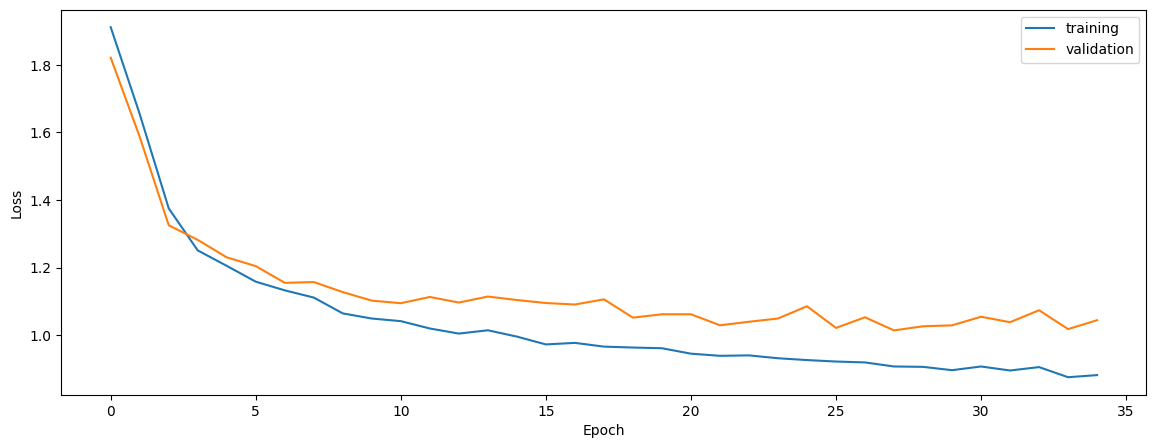

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['threshold'] = 0.6
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASH = getHash(name,[architecture,props])
print(HASH)

sig_100000_2048_1024_512_256_128_0001_MSE_7_1_0_1_1_0_e_e_0_0_0_con_data_nor_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_nat_08_0_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1160792, 828)
(1160792, 1)
validation
(184723, 828)
(184723, 1)
test
(137164, 828)
(137164, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_6 (Dense)             (None, 2048)              1697792   


 dense_7 (Dense)             (None, 1024)              2098176   


 dense_8 (Dense)             (None, 512)               524800    


 dense_9 (Dense)             (None, 256)               131328    


 dense_10 (Dense)            (None, 128)               32896     


 dense_11 (Dense)            (None, 1)                 129       


Total params: 4485121 (17.11 MB)


Trainable params: 4485121 (17.11 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

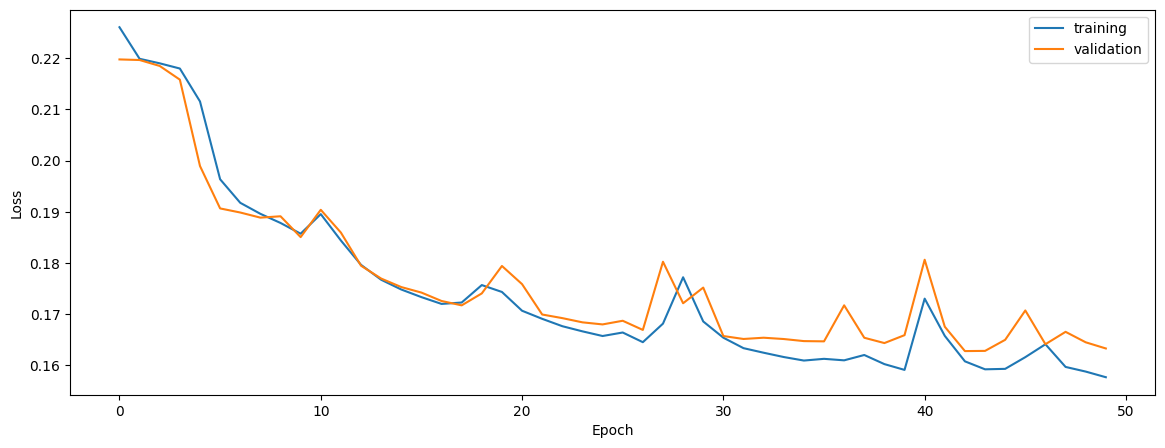

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['not_connected'] = True
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    not_connected = np.where(reg < threshold, 1, 0)
    not_connected = np.expand_dims(not_connected,-1)
    pred = np.concatenate([pred,not_connected],-1)
    for i in range(cla.shape[-1]):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

0.6117844160217797
0.588818466760178
0.5544154264867682


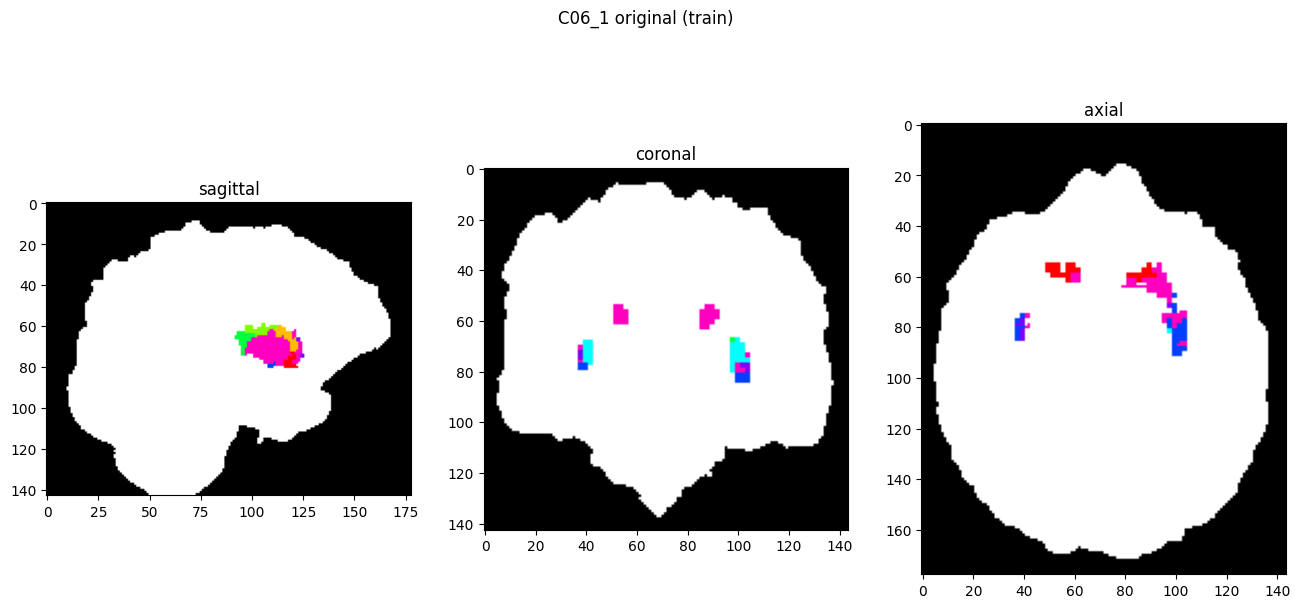

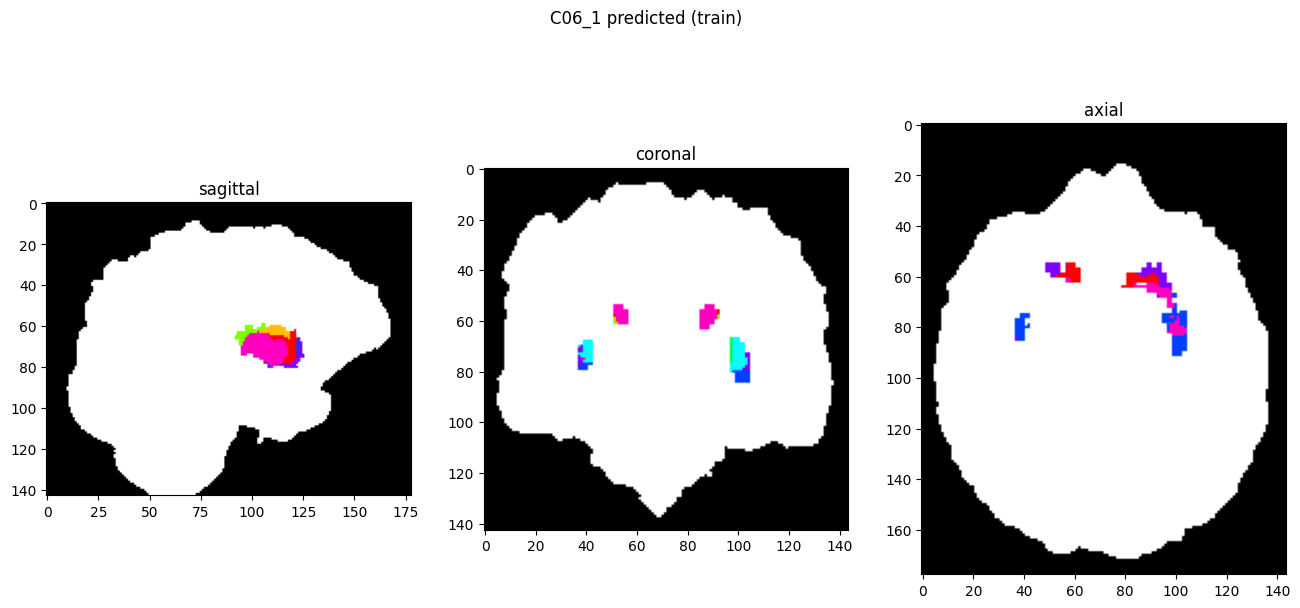

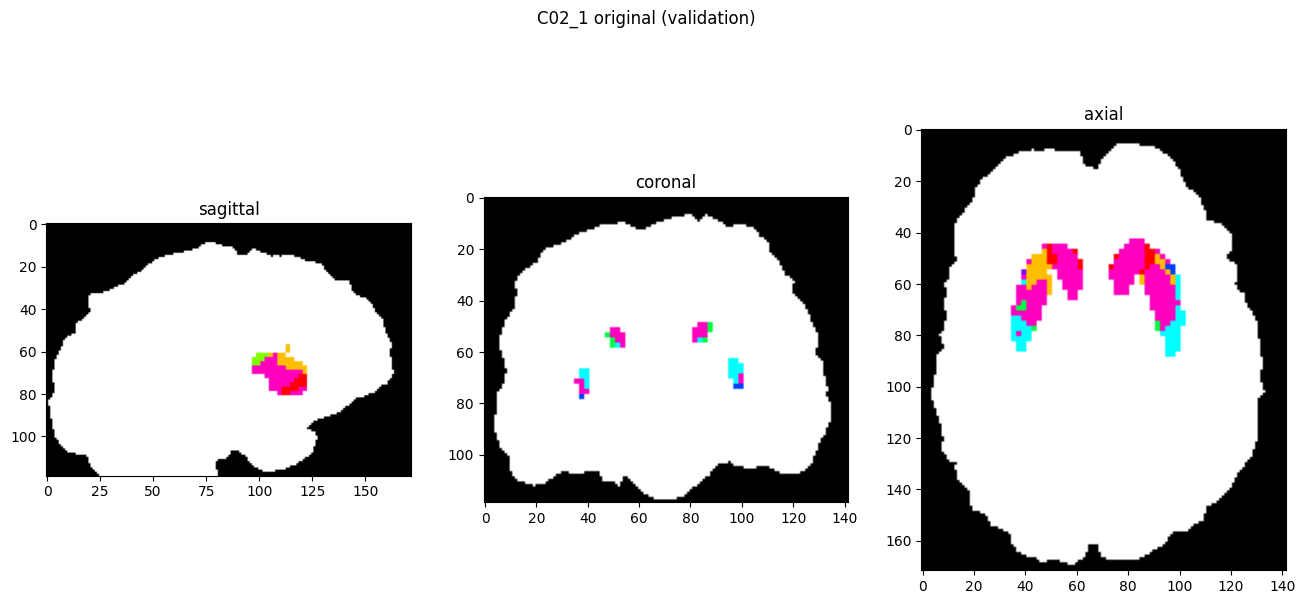

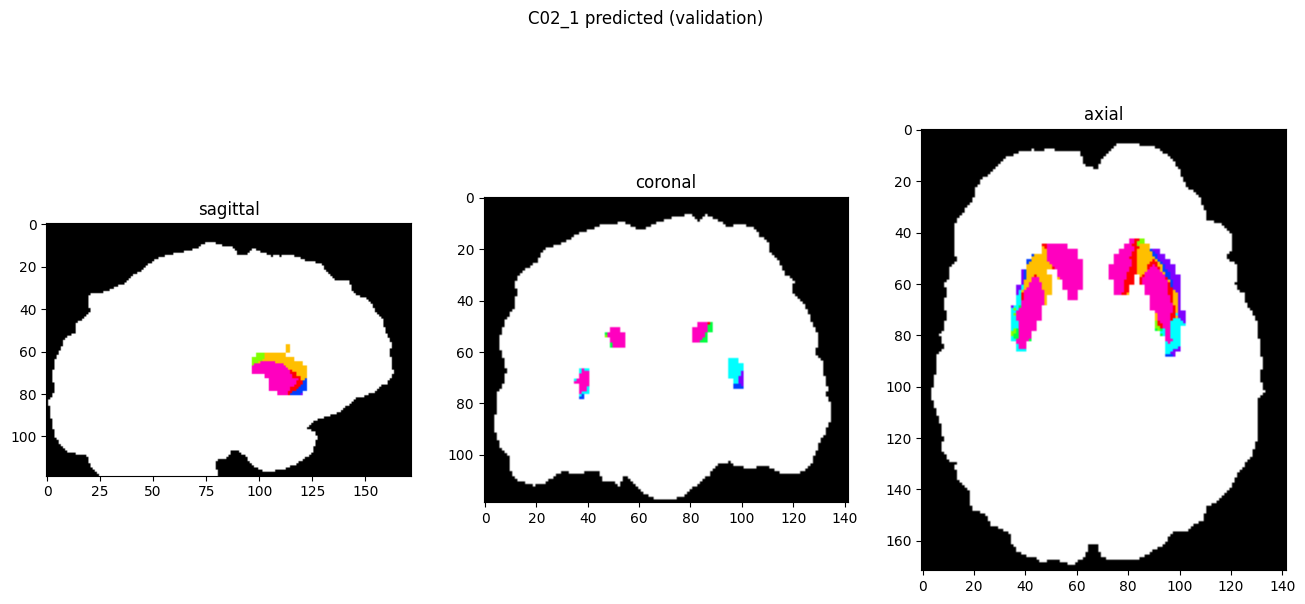

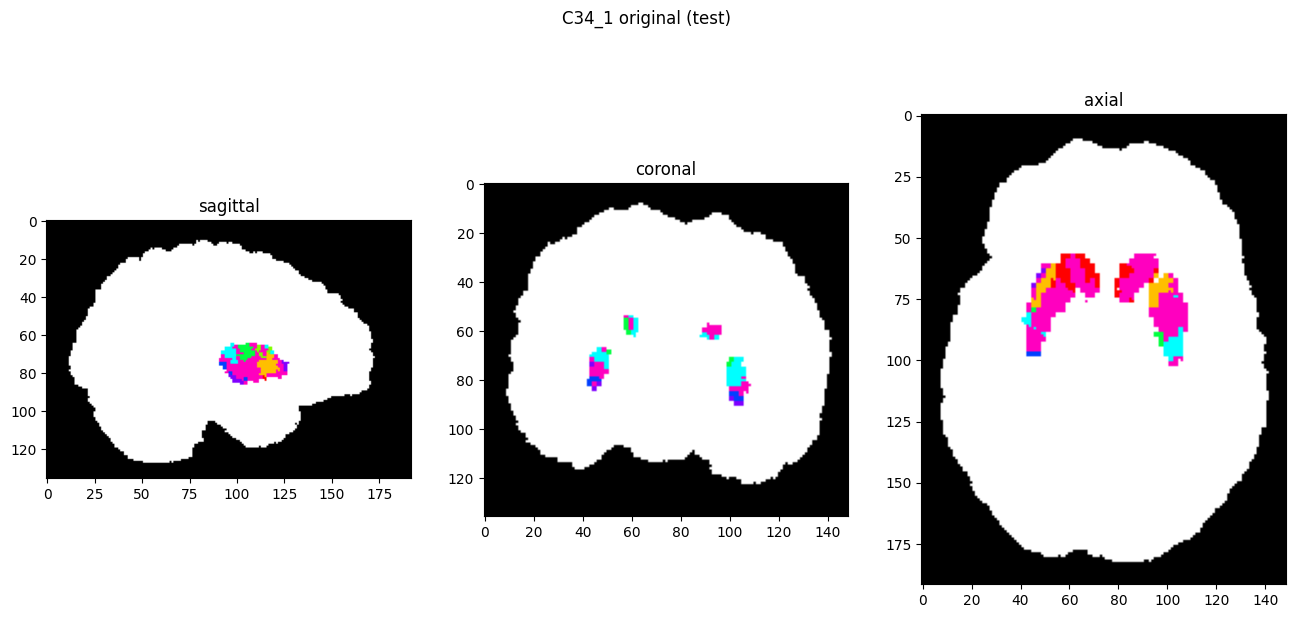

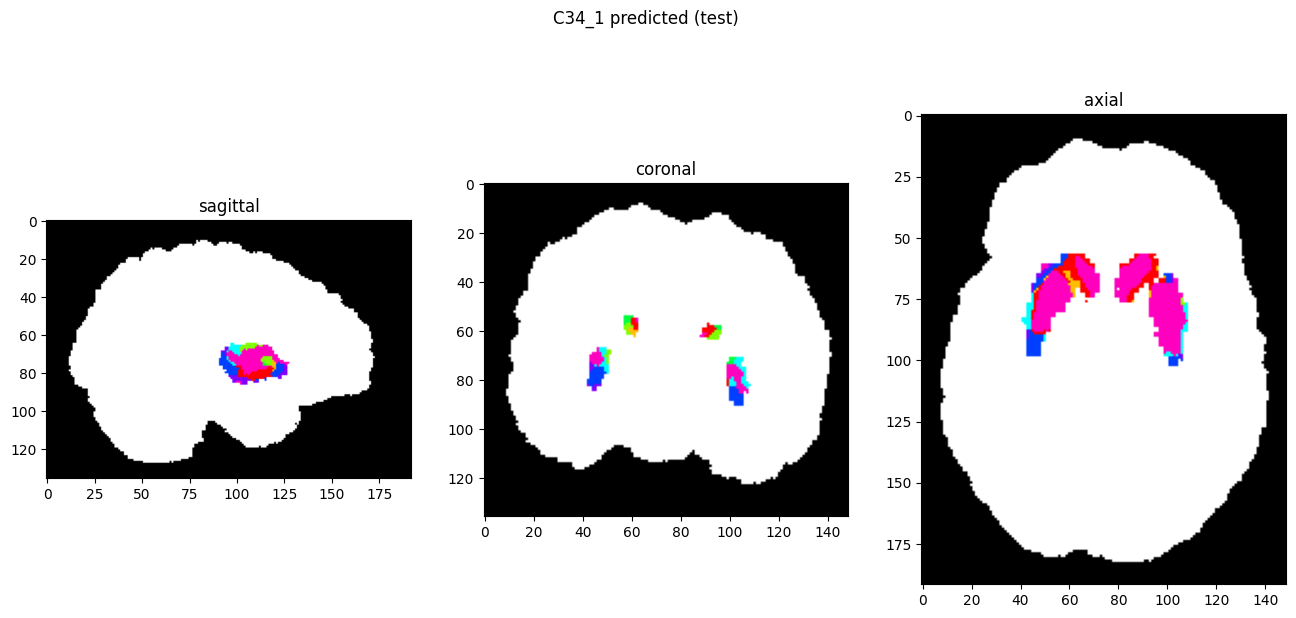

In [16]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)